In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import random
import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import math
import logging
from functools import partial
from collections import OrderedDict
from sklearn.metrics import classification_report
from torchsummary import summary

In [2]:
!nvidia-smi
torch.cuda.is_available()

Fri Sep  3 15:57:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 35%   27C    P8    28W / 260W |   7750MiB / 11011MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [3]:
###Read the EEG Spectrogram###

#Pre-train data
#dat1 = np.load('/home/is/zi-yang/EEG/eeg_c4_seq_5w.npy')
#dat2 = np.load('/home/is/zi-yang/EEG/eeg_c3_seq_5w.npy')

dat1 = np.load('/project/dsc-is/ziwei-y/EEG_C4_seq/np_5007_5793_30.npy')
dat2 = np.load('/project/dsc-is/ziwei-y/EEG_C3_seq/np_c3_5007_5793_30.npy')
print(dat1.shape)
print(dat2.shape)

(786606, 3750)
(786606, 3750)


In [4]:
import gc
del dat1, dat2
gc.collect()

76

In [5]:
###Read the Lable###

#Pre-train label
#index = pd.read_csv('/home/is/zi-yang/EEG/eeg_label_5w.csv', header=None)
index = pd.read_csv("/project/hikaku_db/data/sleep_SHHS/stages_sig/ann_delrecords_5class.csv", header=None)
index = index[0:790121].astype(int)
print(index.apply(pd.value_counts))
label = index.values.tolist()  #list
weight = 1/(index.apply(pd.value_counts)/len(index))
weight = (weight/weight.max()).sort_index()
print(weight)

        0
2  329696
0  221935
4  109008
3  100831
1   28651
          0
0  0.129096
1  1.000000
2  0.086901
3  0.284149
4  0.262834


In [17]:
index = pd.read_csv("/project/hikaku_db/data/sleep_SHHS/stages_sig/ann_delrecords_5class.csv", header=None)
index = index.astype(int)
print(index.apply(pd.value_counts))
weight = (index.apply(pd.value_counts)/len(index))
print(weight)

         0
2  2371496
0  1666191
4   809155
3   732389
1   214985
          0
2  0.409287
0  0.287561
4  0.139649
3  0.126400
1  0.037103


In [6]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1, label ,transform = None):
        self.transform = transform

        self.data1 = data1
        self.label = label

        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float()
        out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1, out_label

In [7]:
train_eeg, test_eeg, train_label, test_label = train_test_split(dat_eeg, np.array(label), test_size = 0.1, stratify = label,random_state = 66)    
print('train eeg data:',len(train_eeg))
print('test eeg data:',len(test_eeg))

train_data_set = Mydatasets(data1 = train_eeg, label = train_label)
test_data_set = Mydatasets(data1 = test_eeg, label = test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

train eeg data: 711108
test eeg data: 79013


In [8]:
del train_eeg, test_eeg
gc.collect()

60

In [3]:
##Inception Transformer model

def create_eeg_conv(kernel, outsize):
    #assert kernel % 2 == 1
    #return nn.Sequential(nn.Conv2d(1, 2, kernel_size=kernel, padding=(kernel - 1) // 2),
    #                     nn.BatchNorm2d(out_chs),
    #                     nn.ReLU(inplace=True))
    return nn.Sequential(nn.Conv1d(2, 2, kernel_size = kernel, padding = 0, stride = kernel),
                         Rearrange('b c (s p) -> b s (p c)', s = 30),
                         nn.Linear(outsize, 8, bias = False),
                         #nn.BatchNorm1d(240),
                         nn.GELU())

#Additional padding for kernel_size=12
def create_eeg_conv_k12(kernel, outsize):
    #assert kernel % 2 == 1
    #return nn.Sequential(nn.Conv2d(1, 2, kernel_size=kernel, padding=(kernel - 1) // 2),
    #                     nn.BatchNorm2d(out_chs),
    #                     nn.ReLU(inplace=True))
    return nn.Sequential(nn.Conv1d(2, 8, kernel_size = kernel, padding = 105, stride = kernel),
                         Rearrange('b c (s p) -> b s (p c)', s = 30),
                         nn.Linear(outsize, 8, bias = False),
                         #nn.BatchNorm1d(240),
                         nn.GELU())

class InceptionModuleEEG(nn.Module):
    def __init__(self, channels):
        assert channels % 2 == 0
        super().__init__()
        # put bottle-neck layers before convolution
        #self.bottleneck = create_encoder_single_conv(channels, bn_ch, 1)
        # bn -> Conv1, 3, 5
        self.conv1 = create_eeg_conv_k12(12, 22)  #22
        self.conv2 = create_eeg_conv(31, 8)      #8
        self.conv3 = create_eeg_conv(62, 4)       #4
        self.conv4 = create_eeg_conv(125, 2)      #2

    def forward(self, x):
        # Original inception is concatenation, but use simple addition instead
        #out = self.conv1(x) + self.conv2(x) + self.conv3(x) + self.conv4(x) 
        out = torch.cat((self.conv1(x), self.conv2(x), self.conv3(x), self.conv4(x)), dim=1)
        return out
    
class PreNorm(nn.Module): 
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads       ##32(4*8)   
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)   ##better to dim to dim*3

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):           ##Register the blocks into whole network
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_dim, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', dim_head, dropout = 0, emb_dropout = 0.):
        super().__init__()
        assert image_size == 30  ##Time dimensions must equal to 30s
        num_patches = 120       
        #patch_dim = 8
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        
        self.eeg_to_patch_embedding = nn.Sequential(
            #Rearrange('b c (h p3) (w p4) -> b (h w) (p3 p4 c)', p3 = 1, p4 = 8),
            nn.Linear(patch_dim, dim),        ##8 to dim
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) ##Generate the pos value'
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))                ##Generate the class value'
        self.dropout = nn.Dropout(emb_dropout)

        self.inceptionEEG = InceptionModuleEEG(dim)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, eeg):
        EEG = self.inceptionEEG(eeg)
        x = self.eeg_to_patch_embedding(EEG)
       #x = torch.cat((EEG, EOG), dim=1)
        
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
Transmodel = ViT(
    image_size = 30, 
    patch_dim = 8,
    num_classes = 5, 
    dim = 64, 
    depth = 8, 
    heads = 4, 
    mlp_dim = 256, 
    dim_head = 8
).to(DEVICE)

pytorch_total_params = sum(p.numel() for p in Transmodel.parameters())
print('total_params:',pytorch_total_params)

optimizer = torch.optim.AdamW(Transmodel.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss() 
#lable weight
#class_weights = torch.FloatTensor(weight.values).to(DEVICE)
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

#Transmodel.load_state_dict(torch.load('/project/hikaku_db/ziwei/Model_4/Model_4_state_1'))

cuda:0
total_params: 343003


In [11]:
EPOCH = 100
loss_list=[]
los_min=10**10
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count=0
    for _, (inputs, labels) in enumerate(train_dataloader, 0):

        optimizer.zero_grad()
        inputs1 = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = Transmodel(inputs1)
        
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        count=count+1

        # print statistics
        running_loss += loss.item()
    loss_loss=running_loss/count
    loss_list.append(loss_loss)
    print('epoch',epoch+1,':finished')
    print('train_loss:',loss_loss)
    with torch.no_grad():
        count=0
        running_loss=0.0
        pre=list()
        lab=list()
        for _, (inputs, labels) in enumerate(test_dataloader, 0):
            inputs1 = inputs.to(DEVICE)
            labels=labels.to(DEVICE)
            outputs = Transmodel(inputs1)
            loss =criterion(outputs, labels.squeeze())
            running_loss += loss.item()
            count+=1
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            predicted=predicted.to('cpu')
            labels=labels.to('cpu')
            predicted=predicted.tolist()
            labels=labels.tolist()
            pre.append(predicted)
            lab.append(labels)
        loss_loss=running_loss/count
        val_loss_list.append(loss_loss)
        pre=sum(pre,[])
        lab=sum(lab,[])
        print('val_loss:',loss_loss)
        cl = classification_report(lab, pre,output_dict=True)
        print(cl)
        ac_list.append(cl['accuracy'])
#         if los_min>loss_loss:
#             los_min=loss_loss
#             torch.save(Transmodel.state_dict(),'Trans_8lay_state') 

        torch.save(Transmodel.state_dict(),'/project/hikaku_db/ziwei/Model_4/Model_4_state_1')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1 :finished
train_loss: 0.7064064683203564


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


val_loss: 0.6319528523968299
{'0': {'precision': 0.8238023630504834, 'recall': 0.8639271875281608, 'f1-score': 0.8433878026787482, 'support': 22194}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2865}, '2': {'precision': 0.7896322178378867, 'recall': 0.7951167728237792, 'f1-score': 0.7923650047605374, 'support': 32970}, '3': {'precision': 0.7718744362258705, 'recall': 0.8486561539224438, 'f1-score': 0.8084463130048656, 'support': 10083}, '4': {'precision': 0.576180913297826, 'recall': 0.6053573066691129, 'f1-score': 0.5904088753690615, 'support': 10901}, 'accuracy': 0.7662663106071153, 'macro avg': {'precision': 0.5922979860824134, 'recall': 0.6226114841886993, 'f1-score': 0.6069215991626425, 'support': 79013}, 'weighted avg': {'precision': 0.7388834994745498, 'recall': 0.7662663106071153, 'f1-score': 0.7521551443943814, 'support': 79013}}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 1/100 [03:39<6:02:00, 219.40s/it]

epoch 2 :finished
train_loss: 0.6106858325195536


  2%|▏         | 2/100 [07:15<5:56:54, 218.51s/it]

val_loss: 0.592635843338754
{'0': {'precision': 0.8157518289941554, 'recall': 0.8992971073263044, 'f1-score': 0.8554895951651272, 'support': 22194}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2865}, '2': {'precision': 0.7827836560108059, 'recall': 0.8437063997573552, 'f1-score': 0.8121040492803548, 'support': 32970}, '3': {'precision': 0.8634859034356809, 'recall': 0.750272736288803, 'f1-score': 0.8029080874548928, 'support': 10083}, '4': {'precision': 0.6309883891111328, 'recall': 0.5932483258416659, 'f1-score': 0.6115366430260046, 'support': 10901}, 'accuracy': 0.7822510219837242, 'macro avg': {'precision': 0.618601955510355, 'recall': 0.6173049138428256, 'f1-score': 0.6164076749852758, 'support': 79013}, 'weighted avg': {'precision': 0.7530166684648726, 'recall': 0.7822510219837242, 'f1-score': 0.7659991364876957, 'support': 79013}}
epoch 3 :finished
train_loss: 0.5827185581991404


  3%|▎         | 3/100 [10:52<5:52:07, 217.81s/it]

val_loss: 0.575950628615584
{'0': {'precision': 0.8425305140106584, 'recall': 0.8833017932774624, 'f1-score': 0.86243456073204, 'support': 22194}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2865}, '2': {'precision': 0.7679323769398966, 'recall': 0.8734910524719441, 'f1-score': 0.8173175161766375, 'support': 32970}, '3': {'precision': 0.871115947285697, 'recall': 0.7145690766636914, 'f1-score': 0.7851149613163342, 'support': 10083}, '4': {'precision': 0.6550340954673085, 'recall': 0.5992110815521512, 'f1-score': 0.6258803238633642, 'support': 10901}, 'accuracy': 0.786452862187235, 'macro avg': {'precision': 0.6273225867407121, 'recall': 0.6141146007930498, 'f1-score': 0.6181494724176751, 'support': 79013}, 'weighted avg': {'precision': 0.7586326486379679, 'recall': 0.786452862187235, 'f1-score': 0.7698336566719117, 'support': 79013}}
epoch 4 :finished
train_loss: 0.5643615731332502


  4%|▍         | 4/100 [14:28<5:48:00, 217.51s/it]

val_loss: 0.5573971436332594
{'0': {'precision': 0.8751695451668324, 'recall': 0.8721726592772822, 'f1-score': 0.8736685322260336, 'support': 22194}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2865}, '2': {'precision': 0.7800765659363037, 'recall': 0.8714285714285714, 'f1-score': 0.823226028280397, 'support': 32970}, '3': {'precision': 0.8510084580351334, 'recall': 0.7783397798274323, 'f1-score': 0.813053613053613, 'support': 10083}, '4': {'precision': 0.6353993728094448, 'recall': 0.6319603706082011, 'f1-score': 0.6336752058133652, 'support': 10901}, 'accuracy': 0.7951223216432739, 'macro avg': {'precision': 0.6283307883895428, 'recall': 0.6307802762282974, 'f1-score': 0.6287246758746817, 'support': 79013}, 'weighted avg': {'precision': 0.7675932328821412, 'recall': 0.7951223216432739, 'f1-score': 0.7800953584298831, 'support': 79013}}
epoch 5 :finished
train_loss: 0.5500691502500538


  5%|▌         | 5/100 [18:05<5:43:52, 217.18s/it]

val_loss: 0.5440676535430707
{'0': {'precision': 0.8294446941527398, 'recall': 0.9146165630350546, 'f1-score': 0.8699509289219363, 'support': 22194}, '1': {'precision': 0.24324324324324326, 'recall': 0.0031413612565445027, 'f1-score': 0.006202618883528601, 'support': 2865}, '2': {'precision': 0.8114299002935961, 'recall': 0.8466484683045192, 'f1-score': 0.8286651526621247, 'support': 32970}, '3': {'precision': 0.8329920131066967, 'recall': 0.8068035306952296, 'f1-score': 0.8196886493022318, 'support': 10083}, '4': {'precision': 0.6750193498452013, 'recall': 0.6400330244931658, 'f1-score': 0.6570607901304328, 'support': 10901}, 'accuracy': 0.8015642995456443, 'macro avg': {'precision': 0.6784258401282954, 'recall': 0.6422485895569027, 'f1-score': 0.6363136279800509, 'support': 79013}, 'weighted avg': {'precision': 0.7798194682826246, 'recall': 0.8015642995456443, 'f1-score': 0.7856187187803433, 'support': 79013}}
epoch 6 :finished
train_loss: 0.5383668660881539


  6%|▌         | 6/100 [21:41<5:39:46, 216.88s/it]

val_loss: 0.53428662383122
{'0': {'precision': 0.8623546763838279, 'recall': 0.8956925295124809, 'f1-score': 0.8787075100561377, 'support': 22194}, '1': {'precision': 0.3548387096774194, 'recall': 0.0038394415357766143, 'f1-score': 0.007596685082872928, 'support': 2865}, '2': {'precision': 0.8018218111276674, 'recall': 0.8650288140734, 'f1-score': 0.8322269073082478, 'support': 32970}, '3': {'precision': 0.8538982310548154, 'recall': 0.775562828523257, 'f1-score': 0.8128475650953694, 'support': 10083}, '4': {'precision': 0.6550031241631705, 'recall': 0.6731492523621686, 'f1-score': 0.6639522258414766, 'support': 10901}, 'accuracy': 0.8045258375204081, 'macro avg': {'precision': 0.7055833104813801, 'recall': 0.6426545732014166, 'f1-score': 0.6390661786768208, 'support': 79013}, 'weighted avg': {'precision': 0.7890071586194183, 'recall': 0.8045258375204081, 'f1-score': 0.7896929027837929, 'support': 79013}}
epoch 7 :finished
train_loss: 0.5290025109244153


  7%|▋         | 7/100 [25:17<5:35:52, 216.69s/it]

val_loss: 0.5273627980517955
{'0': {'precision': 0.8835764451647758, 'recall': 0.8842930521762639, 'f1-score': 0.8839346034319687, 'support': 22194}, '1': {'precision': 0.3380281690140845, 'recall': 0.008376963350785341, 'f1-score': 0.01634877384196185, 'support': 2865}, '2': {'precision': 0.8025900900900901, 'recall': 0.864664846830452, 'f1-score': 0.8324718937071105, 'support': 32970}, '3': {'precision': 0.8407934364939246, 'recall': 0.8029356342358425, 'f1-score': 0.8214285714285715, 'support': 10083}, '4': {'precision': 0.6526206717900008, 'recall': 0.6933308870745803, 'f1-score': 0.6723601103104706, 'support': 10901}, 'accuracy': 0.8076139369470846, 'macro avg': {'precision': 0.7035217625105752, 'recall': 0.6507202767335848, 'f1-score': 0.6453087905440167, 'support': 79013}, 'weighted avg': {'precision': 0.7926781638696632, 'recall': 0.8076139369470846, 'f1-score': 0.79383574866615, 'support': 79013}}
epoch 8 :finished
train_loss: 0.5210621434540801


  8%|▊         | 8/100 [28:54<5:32:14, 216.68s/it]

val_loss: 0.5205802315159848
{'0': {'precision': 0.8745546514185177, 'recall': 0.895872758403172, 'f1-score': 0.8850853568964367, 'support': 22194}, '1': {'precision': 0.16666666666666666, 'recall': 0.00034904013961605586, 'f1-score': 0.0006966213862765587, 'support': 2865}, '2': {'precision': 0.803312109025916, 'recall': 0.8724598119502578, 'f1-score': 0.8364593329262265, 'support': 32970}, '3': {'precision': 0.8685109289617486, 'recall': 0.7566200535554894, 'f1-score': 0.8087136269677213, 'support': 10083}, '4': {'precision': 0.6576198630136987, 'recall': 0.7046142555728833, 'f1-score': 0.6803064523271778, 'support': 10901}, 'accuracy': 0.8094743902902054, 'macro avg': {'precision': 0.6741328438173095, 'recall': 0.6459831839242837, 'f1-score': 0.6422522781007678, 'support': 79013}, 'weighted avg': {'precision': 0.788458557346268, 'recall': 0.8094743902902054, 'f1-score': 0.7947290265569334, 'support': 79013}}
epoch 9 :finished
train_loss: 0.5146138346609858


  9%|▉         | 9/100 [32:30<5:28:27, 216.56s/it]

val_loss: 0.5172415280149051
{'0': {'precision': 0.8636188519327084, 'recall': 0.909029467423628, 'f1-score': 0.8857425090549885, 'support': 22194}, '1': {'precision': 0.336322869955157, 'recall': 0.02617801047120419, 'f1-score': 0.048575129533678756, 'support': 2865}, '2': {'precision': 0.8192015932987728, 'recall': 0.8483469821049439, 'f1-score': 0.8335195863692577, 'support': 32970}, '3': {'precision': 0.8371451909332244, 'recall': 0.8131508479619161, 'f1-score': 0.8249735875635156, 'support': 10083}, '4': {'precision': 0.6683780020884094, 'recall': 0.7046142555728833, 'f1-score': 0.6860179520385835, 'support': 10901}, 'accuracy': 0.8112589067621784, 'macro avg': {'precision': 0.7049333016416544, 'recall': 0.6602639127069151, 'f1-score': 0.6557657529120048, 'support': 79013}, 'weighted avg': {'precision': 0.7956503602473269, 'recall': 0.8112589067621784, 'f1-score': 0.798285954630888, 'support': 79013}}
epoch 10 :finished
train_loss: 0.5090541313244787


 10%|█         | 10/100 [36:07<5:25:01, 216.69s/it]

val_loss: 0.5150954619592983
{'0': {'precision': 0.8394437420986094, 'recall': 0.9274578714968009, 'f1-score': 0.8812586963502088, 'support': 22194}, '1': {'precision': 0.3181818181818182, 'recall': 0.004886561954624782, 'f1-score': 0.009625300790649709, 'support': 2865}, '2': {'precision': 0.8291299805999105, 'recall': 0.8425841674249318, 'f1-score': 0.8358029334336217, 'support': 32970}, '3': {'precision': 0.8482736775419703, 'recall': 0.79678667063374, 'f1-score': 0.8217244553544033, 'support': 10083}, '4': {'precision': 0.674163179916318, 'recall': 0.7094761948445096, 'f1-score': 0.6913690609216465, 'support': 10901}, 'accuracy': 0.8118410894409781, 'macro avg': {'precision': 0.7018384796677253, 'recall': 0.6562382932709214, 'f1-score': 0.647956089370106, 'support': 79013}, 'weighted avg': {'precision': 0.7945631364019841, 'recall': 0.8118410894409781, 'f1-score': 0.7968905942732661, 'support': 79013}}
epoch 11 :finished
train_loss: 0.5042882973477083


 11%|█         | 11/100 [39:44<5:21:20, 216.63s/it]

val_loss: 0.5066839237203482
{'0': {'precision': 0.8705135403619402, 'recall': 0.9081283229701721, 'f1-score': 0.8889231922729177, 'support': 22194}, '1': {'precision': 0.3644859813084112, 'recall': 0.027225130890052355, 'f1-score': 0.05066580058460539, 'support': 2865}, '2': {'precision': 0.8149145164523611, 'recall': 0.8630876554443433, 'f1-score': 0.8383095936013198, 'support': 32970}, '3': {'precision': 0.8640830297007839, 'recall': 0.7761578895170088, 'f1-score': 0.8177638453500523, 'support': 10083}, '4': {'precision': 0.6706940874035989, 'recall': 0.7180075222456656, 'f1-score': 0.6935448141420406, 'support': 10901}, 'accuracy': 0.8143216938984724, 'macro avg': {'precision': 0.7169382310454191, 'recall': 0.6585213042134483, 'f1-score': 0.6578414491901872, 'support': 79013}, 'weighted avg': {'precision': 0.8005764481026602, 'recall': 0.8143216938984724, 'f1-score': 0.8013723187404922, 'support': 79013}}
epoch 12 :finished
train_loss: 0.49961532762742156


 12%|█▏        | 12/100 [43:20<5:17:49, 216.70s/it]

val_loss: 0.5034950741148188
{'0': {'precision': 0.8610547667342799, 'recall': 0.9180859691808597, 'f1-score': 0.8886562867983777, 'support': 22194}, '1': {'precision': 0.37209302325581395, 'recall': 0.033507853403141365, 'f1-score': 0.06147934678194045, 'support': 2865}, '2': {'precision': 0.8069651185522384, 'recall': 0.8764027904155293, 'f1-score': 0.8402518283728572, 'support': 32970}, '3': {'precision': 0.8633753037331566, 'recall': 0.775265298026381, 'f1-score': 0.8169514552960233, 'support': 10083}, '4': {'precision': 0.7134897360703812, 'recall': 0.6695715989358775, 'f1-score': 0.6908333727698641, 'support': 10901}, 'accuracy': 0.8161062103704454, 'macro avg': {'precision': 0.723395589669174, 'recall': 0.6545667019923578, 'f1-score': 0.6596344580038126, 'support': 79013}, 'weighted avg': {'precision': 0.8006923008067085, 'recall': 0.8161062103704454, 'f1-score': 0.8020221338197593, 'support': 79013}}
epoch 13 :finished
train_loss: 0.4958958937669182


 13%|█▎        | 13/100 [46:56<5:13:53, 216.48s/it]

val_loss: 0.499429198532452
{'0': {'precision': 0.8772648083623693, 'recall': 0.9075425790754258, 'f1-score': 0.8921468751384152, 'support': 22194}, '1': {'precision': 0.35148514851485146, 'recall': 0.04956369982547993, 'f1-score': 0.08687672070969715, 'support': 2865}, '2': {'precision': 0.8172721277632824, 'recall': 0.8645435244161359, 'f1-score': 0.8402434890267808, 'support': 32970}, '3': {'precision': 0.859262444898398, 'recall': 0.792621243677477, 'f1-score': 0.824597606273215, 'support': 10083}, '4': {'precision': 0.6816319414174876, 'recall': 0.7172736446197596, 'f1-score': 0.6989987484355444, 'support': 10901}, 'accuracy': 0.8175743232126359, 'macro avg': {'precision': 0.7173832941912778, 'recall': 0.6663089383228555, 'f1-score': 0.6685726879167305, 'support': 79013}, 'weighted avg': {'precision': 0.8038790475611288, 'recall': 0.8175743232126359, 'f1-score': 0.806022305261374, 'support': 79013}}
epoch 14 :finished
train_loss: 0.49205027515426697


 14%|█▍        | 14/100 [50:33<5:10:21, 216.53s/it]

val_loss: 0.5025694960765993
{'0': {'precision': 0.887633979980512, 'recall': 0.9029917995854736, 'f1-score': 0.8952470293933709, 'support': 22194}, '1': {'precision': 0.31044776119402984, 'recall': 0.03630017452006981, 'f1-score': 0.065, 'support': 2865}, '2': {'precision': 0.8027079303675049, 'recall': 0.8685168334849863, 'f1-score': 0.834316681963201, 'support': 32970}, '3': {'precision': 0.8078962317742852, 'recall': 0.8462759099474363, 'f1-score': 0.8266408331315088, 'support': 10083}, '4': {'precision': 0.7127217435377597, 'recall': 0.6449866984680305, 'f1-score': 0.6771645959741885, 'support': 10901}, 'accuracy': 0.814347006188855, 'macro avg': {'precision': 0.7042815293708184, 'recall': 0.6598142832011993, 'f1-score': 0.6596738280924539, 'support': 79013}, 'weighted avg': {'precision': 0.7969607442194353, 'recall': 0.814347006188855, 'f1-score': 0.8008751642876848, 'support': 79013}}
epoch 15 :finished
train_loss: 0.4886395891201719


 15%|█▌        | 15/100 [53:55<5:00:38, 212.21s/it]

val_loss: 0.4927706972548836
{'0': {'precision': 0.8930313744797028, 'recall': 0.8990267639902676, 'f1-score': 0.8960190403484742, 'support': 22194}, '1': {'precision': 0.34591194968553457, 'recall': 0.038394415357766144, 'f1-score': 0.0691171850455545, 'support': 2865}, '2': {'precision': 0.8168788899674527, 'recall': 0.8678192296026691, 'f1-score': 0.8415789164068475, 'support': 32970}, '3': {'precision': 0.8438692379086316, 'recall': 0.8115640186452445, 'f1-score': 0.8274014155712841, 'support': 10083}, '4': {'precision': 0.678390231318256, 'recall': 0.723695073846436, 'f1-score': 0.7003106968486461, 'support': 10901}, 'accuracy': 0.819447432700948, 'macro avg': {'precision': 0.7156163366719156, 'recall': 0.6680999002884767, 'f1-score': 0.6668854508441614, 'support': 79013}, 'weighted avg': {'precision': 0.805529957104673, 'recall': 0.819447432700948, 'f1-score': 0.8075620413113749, 'support': 79013}}
epoch 16 :finished
train_loss: 0.4852973553073801


 16%|█▌        | 16/100 [57:31<4:58:39, 213.33s/it]

val_loss: 0.49119409144166026
{'0': {'precision': 0.8698791063266265, 'recall': 0.9175002252861134, 'f1-score': 0.8930552814507816, 'support': 22194}, '1': {'precision': 0.38596491228070173, 'recall': 0.038394415357766144, 'f1-score': 0.06984126984126984, 'support': 2865}, '2': {'precision': 0.8143862037667348, 'recall': 0.8708522899605702, 'f1-score': 0.8416732623926363, 'support': 32970}, '3': {'precision': 0.8578750667378537, 'recall': 0.79678667063374, 'f1-score': 0.8262032085561497, 'support': 10083}, '4': {'precision': 0.7086371284352215, 'recall': 0.6954407852490597, 'f1-score': 0.7019769433770082, 'support': 10901}, 'accuracy': 0.8201182083960867, 'macro avg': {'precision': 0.7273484835094277, 'recall': 0.6637948772974498, 'f1-score': 0.6665499931235691, 'support': 79013}, 'weighted avg': {'precision': 0.8053992018107999, 'recall': 0.8201182083960867, 'f1-score': 0.8068721504983171, 'support': 79013}}
epoch 17 :finished
train_loss: 0.4825355367301886


 17%|█▋        | 17/100 [1:01:07<4:56:14, 214.15s/it]

val_loss: 0.492407223871845
{'0': {'precision': 0.8776893988786022, 'recall': 0.9098404974317383, 'f1-score': 0.8934758080573438, 'support': 22194}, '1': {'precision': 0.32341269841269843, 'recall': 0.0568935427574171, 'f1-score': 0.09676461858118136, 'support': 2865}, '2': {'precision': 0.8335164019593291, 'recall': 0.8515923566878981, 'f1-score': 0.8424574300502587, 'support': 32970}, '3': {'precision': 0.83550307800989, 'recall': 0.8210849945452742, 'f1-score': 0.8282312925170068, 'support': 10083}, '4': {'precision': 0.6774437353039973, 'recall': 0.740023851022842, 'f1-score': 0.707352360910167, 'support': 10901}, 'accuracy': 0.8198524293470695, 'macro avg': {'precision': 0.7095130625129034, 'recall': 0.6758870484890339, 'f1-score': 0.6736563020231915, 'support': 79013}, 'weighted avg': {'precision': 0.8061489041852069, 'recall': 0.8198524293470695, 'f1-score': 0.8092941464537168, 'support': 79013}}
epoch 18 :finished
train_loss: 0.47994988952757345


 18%|█▊        | 18/100 [1:04:43<4:53:27, 214.73s/it]

val_loss: 0.48849621047133857
{'0': {'precision': 0.8693135878122473, 'recall': 0.920428944759845, 'f1-score': 0.894141334558904, 'support': 22194}, '1': {'precision': 0.366120218579235, 'recall': 0.046771378708551484, 'f1-score': 0.08294645620550914, 'support': 2865}, '2': {'precision': 0.8129964912280702, 'recall': 0.8784652714589021, 'f1-score': 0.8444638822071581, 'support': 32970}, '3': {'precision': 0.8672353455818023, 'recall': 0.7864722800753744, 'f1-score': 0.8248816768086545, 'support': 10083}, '4': {'precision': 0.7194334714327006, 'recall': 0.6849830290799009, 'f1-score': 0.7017857142857143, 'support': 10901}, 'accuracy': 0.8216622581094251, 'macro avg': {'precision': 0.7270198229268111, 'recall': 0.6634241808165149, 'f1-score': 0.669643812813188, 'support': 79013}, 'weighted avg': {'precision': 0.806624894277058, 'recall': 0.8216622581094251, 'f1-score': 0.8086218292089825, 'support': 79013}}
epoch 19 :finished
train_loss: 0.4771253618554536


 19%|█▉        | 19/100 [1:08:19<4:50:25, 215.14s/it]

val_loss: 0.48707656675746086
{'0': {'precision': 0.8837829565825718, 'recall': 0.9107416418851942, 'f1-score': 0.8970598025074893, 'support': 22194}, '1': {'precision': 0.35119047619047616, 'recall': 0.020593368237347295, 'f1-score': 0.03890537421694691, 'support': 2865}, '2': {'precision': 0.8230164896831563, 'recall': 0.867424931756142, 'f1-score': 0.8446373986621185, 'support': 32970}, '3': {'precision': 0.881110985661059, 'recall': 0.7739759992065853, 'f1-score': 0.8240760295670538, 'support': 10083}, '4': {'precision': 0.6655886157826649, 'recall': 0.7551600770571507, 'f1-score': 0.7075508186858052, 'support': 10901}, 'accuracy': 0.8214724159315556, 'macro avg': {'precision': 0.7209379047799856, 'recall': 0.665579203628484, 'f1-score': 0.6624458847278828, 'support': 79013}, 'weighted avg': {'precision': 0.8086709387898228, 'recall': 0.8214724159315556, 'f1-score': 0.8086096499119309, 'support': 79013}}
epoch 20 :finished
train_loss: 0.4749077109189515


 20%|██        | 20/100 [1:11:54<4:46:45, 215.07s/it]

val_loss: 0.4912526594120481
{'0': {'precision': 0.8561228725612288, 'recall': 0.9292601604037127, 'f1-score': 0.8911935009938641, 'support': 22194}, '1': {'precision': 0.4072164948453608, 'recall': 0.02757417102966841, 'f1-score': 0.05165086629617522, 'support': 2865}, '2': {'precision': 0.8229232811868614, 'recall': 0.864755838641189, 'f1-score': 0.8433211074301942, 'support': 32970}, '3': {'precision': 0.8388754534461911, 'recall': 0.8256471288307051, 'f1-score': 0.832208726945569, 'support': 10083}, '4': {'precision': 0.7266463234570332, 'recall': 0.677185579304651, 'f1-score': 0.7010446343779677, 'support': 10901}, 'accuracy': 0.8216496019642338, 'macro avg': {'precision': 0.730356885099335, 'recall': 0.6648845756419852, 'f1-score': 0.663883767208754, 'support': 79013}, 'weighted avg': {'precision': 0.8059281338664492, 'recall': 0.8216496019642338, 'f1-score': 0.8070149640959876, 'support': 79013}}
epoch 21 :finished
train_loss: 0.4726687084516018


 21%|██        | 21/100 [1:15:30<4:43:29, 215.31s/it]

val_loss: 0.4849614563499868
{'0': {'precision': 0.8925156757237515, 'recall': 0.9042984590429846, 'f1-score': 0.8983684340099819, 'support': 22194}, '1': {'precision': 0.3870967741935484, 'recall': 0.03769633507853403, 'f1-score': 0.06870229007633588, 'support': 2865}, '2': {'precision': 0.8108348134991119, 'recall': 0.8861389141643918, 'f1-score': 0.8468160343178458, 'support': 32970}, '3': {'precision': 0.8732097257688465, 'recall': 0.7800257859763959, 'f1-score': 0.8239916186485071, 'support': 10083}, '4': {'precision': 0.6979835831548894, 'recall': 0.7176405834327126, 'f1-score': 0.7076756072187795, 'support': 10901}, 'accuracy': 0.8236872413400327, 'macro avg': {'precision': 0.7323281144680295, 'recall': 0.6651600155390038, 'f1-score': 0.66911079685429, 'support': 79013}, 'weighted avg': {'precision': 0.8108038129300483, 'recall': 0.8236872413400327, 'f1-score': 0.8109731945638113, 'support': 79013}}
epoch 22 :finished
train_loss: 0.47038117877715263


 22%|██▏       | 22/100 [1:19:06<4:40:00, 215.39s/it]

val_loss: 0.4854000081296874
{'0': {'precision': 0.87141823136203, 'recall': 0.922186176444084, 'f1-score': 0.896083710952037, 'support': 22194}, '1': {'precision': 0.41148325358851673, 'recall': 0.0300174520069808, 'f1-score': 0.05595315549772284, 'support': 2865}, '2': {'precision': 0.8341993527123727, 'recall': 0.8521383075523203, 'f1-score': 0.8430734144548305, 'support': 32970}, '3': {'precision': 0.8134651600753295, 'recall': 0.8567886541703857, 'f1-score': 0.8345650388832536, 'support': 10083}, '4': {'precision': 0.7078417135596297, 'recall': 0.715438950554995, 'f1-score': 0.7116200556594735, 'support': 10901}, 'accuracy': 0.8237378659207979, 'macro avg': {'precision': 0.7276815422595757, 'recall': 0.6753139081457531, 'f1-score': 0.6682590750894635, 'support': 79013}, 'weighted avg': {'precision': 0.8092473407649374, 'recall': 0.8237378659207979, 'f1-score': 0.8102009499670944, 'support': 79013}}
epoch 23 :finished
train_loss: 0.4684448103152907


 23%|██▎       | 23/100 [1:22:41<4:36:31, 215.47s/it]

val_loss: 0.48658026367546575
{'0': {'precision': 0.8962407357799803, 'recall': 0.9044786879336758, 'f1-score': 0.900340868317187, 'support': 22194}, '1': {'precision': 0.36123348017621143, 'recall': 0.028621291448516578, 'f1-score': 0.053040103492884856, 'support': 2865}, '2': {'precision': 0.8037640325775919, 'recall': 0.8860175917500758, 'f1-score': 0.8428888824768443, 'support': 32970}, '3': {'precision': 0.8455076324147116, 'recall': 0.8185063969056828, 'f1-score': 0.8317879459786333, 'support': 10083}, '4': {'precision': 0.7210930662258096, 'recall': 0.6802128245115127, 'f1-score': 0.7000566465256797, 'support': 10901}, 'accuracy': 0.823105058661233, 'macro avg': {'precision': 0.725567789434861, 'recall': 0.6635673585098927, 'f1-score': 0.6656228893582459, 'support': 79013}, 'weighted avg': {'precision': 0.8076150752060296, 'recall': 0.823105058661233, 'f1-score': 0.8092643861931493, 'support': 79013}}
epoch 24 :finished
train_loss: 0.4665293149499905
val_loss: 0.4857544846983573

 24%|██▍       | 24/100 [1:26:18<4:33:14, 215.71s/it]

epoch 25 :finished
train_loss: 0.4645005925065691


 25%|██▌       | 25/100 [1:29:58<4:31:25, 217.14s/it]

val_loss: 0.4874952309768692
{'0': {'precision': 0.8940636420358321, 'recall': 0.9038929440389294, 'f1-score': 0.8989514249865567, 'support': 22194}, '1': {'precision': 0.3611111111111111, 'recall': 0.040837696335078534, 'f1-score': 0.07337723424270931, 'support': 2865}, '2': {'precision': 0.7972408589981947, 'recall': 0.897421898695784, 'f1-score': 0.8443702467074755, 'support': 32970}, '3': {'precision': 0.8641280830809174, 'recall': 0.792224536348309, 'f1-score': 0.826615615460237, 'support': 10083}, '4': {'precision': 0.7328684050939963, 'recall': 0.6651683331804421, 'f1-score': 0.697379177686944, 'support': 10901}, 'accuracy': 0.8227127181603028, 'macro avg': {'precision': 0.7298824200640104, 'recall': 0.6599090817197085, 'f1-score': 0.6681387398167844, 'support': 79013}, 'weighted avg': {'precision': 0.8082779399779987, 'recall': 0.8227127181603028, 'f1-score': 0.8092002126593523, 'support': 79013}}
epoch 26 :finished
train_loss: 0.46249347045156725


 26%|██▌       | 26/100 [1:33:24<4:23:35, 213.73s/it]

val_loss: 0.47882466557537495
{'0': {'precision': 0.8928698119900674, 'recall': 0.907272235739389, 'f1-score': 0.9000134090198006, 'support': 22194}, '1': {'precision': 0.39593908629441626, 'recall': 0.027225130890052355, 'f1-score': 0.05094709340300457, 'support': 2865}, '2': {'precision': 0.8419419931933861, 'recall': 0.8478920230512588, 'f1-score': 0.8449065328759464, 'support': 32970}, '3': {'precision': 0.8243803645481724, 'recall': 0.8477635624318159, 'f1-score': 0.8359084686094269, 'support': 10083}, '4': {'precision': 0.6682949889694295, 'recall': 0.7780937528667095, 'f1-score': 0.7190268299919468, 'support': 10901}, 'accuracy': 0.8251680103274145, 'macro avg': {'precision': 0.7246852489990943, 'recall': 0.6816493409958452, 'f1-score': 0.670160466780025, 'support': 79013}, 'weighted avg': {'precision': 0.8138769126045331, 'recall': 0.8251680103274145, 'f1-score': 0.8130814672779931, 'support': 79013}}
epoch 27 :finished
train_loss: 0.4608548802449023


 27%|██▋       | 27/100 [1:36:58<4:20:08, 213.81s/it]

val_loss: 0.4801328238326046
{'0': {'precision': 0.8949993320568197, 'recall': 0.9056051185004956, 'f1-score': 0.9002709905713199, 'support': 22194}, '1': {'precision': 0.37389380530973454, 'recall': 0.05898778359511344, 'f1-score': 0.10189930660235154, 'support': 2865}, '2': {'precision': 0.8195448079658606, 'recall': 0.8737336973005763, 'f1-score': 0.845772166764533, 'support': 32970}, '3': {'precision': 0.8359296984222089, 'recall': 0.8302092631161361, 'f1-score': 0.8330596606458675, 'support': 10083}, '4': {'precision': 0.7094149908592322, 'recall': 0.711953031831942, 'f1-score': 0.7106817453413304, 'support': 10901}, 'accuracy': 0.8252692594889448, 'macro avg': {'precision': 0.7267565269227713, 'recall': 0.6760977788688527, 'f1-score': 0.6783367739850805, 'support': 79013}, 'weighted avg': {'precision': 0.8114769115343488, 'recall': 0.8252692594889448, 'f1-score': 0.8138476767195321, 'support': 79013}}
epoch 28 :finished
train_loss: 0.4588634990600908


 28%|██▊       | 28/100 [1:40:35<4:17:38, 214.70s/it]

val_loss: 0.4810101779366312
{'0': {'precision': 0.8903319538610549, 'recall': 0.9111922141119222, 'f1-score': 0.9006413111249666, 'support': 22194}, '1': {'precision': 0.38345864661654133, 'recall': 0.0356020942408377, 'f1-score': 0.0651549025870329, 'support': 2865}, '2': {'precision': 0.8260053696700251, 'recall': 0.8678192296026691, 'f1-score': 0.84639618985638, 'support': 32970}, '3': {'precision': 0.8503977683645004, 'recall': 0.8163245065952593, 'f1-score': 0.8330128529501062, 'support': 10083}, '4': {'precision': 0.6874093043107128, 'recall': 0.7387395651775066, 'f1-score': 0.7121506897771489, 'support': 10901}, 'accuracy': 0.825446445521623, 'macro avg': {'precision': 0.7275206085645669, 'recall': 0.6739355219456391, 'f1-score': 0.671471189259127, 'support': 79013}, 'weighted avg': {'precision': 0.812018819299099, 'recall': 0.825446445521623, 'f1-score': 0.8130764266657491, 'support': 79013}}
epoch 29 :finished
train_loss: 0.4572536193030163


 29%|██▉       | 29/100 [1:44:11<4:14:33, 215.12s/it]

val_loss: 0.4806908777126899
{'0': {'precision': 0.8903015053193838, 'recall': 0.9087140668649184, 'f1-score': 0.8994135616652174, 'support': 22194}, '1': {'precision': 0.3567567567567568, 'recall': 0.06910994764397906, 'f1-score': 0.11578947368421053, 'support': 2865}, '2': {'precision': 0.8210202161329874, 'recall': 0.8733393994540491, 'f1-score': 0.8463720403874135, 'support': 32970}, '3': {'precision': 0.8445165213865802, 'recall': 0.826341366656749, 'f1-score': 0.8353300917339215, 'support': 10083}, '4': {'precision': 0.7095141700404858, 'recall': 0.7073662966700303, 'f1-score': 0.7084386053562406, 'support': 10901}, 'accuracy': 0.8252186349081797, 'macro avg': {'precision': 0.7244218339272388, 'recall': 0.6769742154579452, 'f1-score': 0.6810687545654007, 'support': 79013}, 'weighted avg': {'precision': 0.8112610620508438, 'recall': 0.8252186349081797, 'f1-score': 0.8143410597397597, 'support': 79013}}
epoch 30 :finished
train_loss: 0.455557424773558


 30%|███       | 30/100 [1:47:41<4:09:13, 213.63s/it]

val_loss: 0.47589390631388073
{'0': {'precision': 0.8793519476042744, 'recall': 0.9195278003063891, 'f1-score': 0.8989912338663496, 'support': 22194}, '1': {'precision': 0.3542234332425068, 'recall': 0.04537521815008726, 'f1-score': 0.08044554455445543, 'support': 2865}, '2': {'precision': 0.825059440258959, 'recall': 0.8735820442826813, 'f1-score': 0.8486277051812784, 'support': 32970}, '3': {'precision': 0.8557752341311134, 'recall': 0.8156302687692155, 'f1-score': 0.8352206367744884, 'support': 10083}, '4': {'precision': 0.7157248832310651, 'recall': 0.7169067058068067, 'f1-score': 0.7163153070577452, 'support': 10901}, 'accuracy': 0.8274461164618481, 'macro avg': {'precision': 0.7260269876935838, 'recall': 0.674204407463036, 'f1-score': 0.6759200854868634, 'support': 79013}, 'weighted avg': {'precision': 0.8120726417748065, 'recall': 0.8274461164618481, 'f1-score': 0.8149548329039357, 'support': 79013}}
epoch 31 :finished
train_loss: 0.4539777912679574


 31%|███       | 31/100 [1:51:15<4:05:53, 213.82s/it]

val_loss: 0.48256925958612185
{'0': {'precision': 0.9017913403546673, 'recall': 0.9027665134721096, 'f1-score': 0.9022786634242997, 'support': 22194}, '1': {'precision': 0.3533697632058288, 'recall': 0.06771378708551483, 'f1-score': 0.1136496777973052, 'support': 2865}, '2': {'precision': 0.8123496166974428, 'recall': 0.8806490749165908, 'f1-score': 0.8451216672488067, 'support': 32970}, '3': {'precision': 0.8358297787917865, 'recall': 0.8356639888921947, 'f1-score': 0.8357468756199167, 'support': 10083}, '4': {'precision': 0.7221529310179411, 'recall': 0.690487111274195, 'f1-score': 0.7059651097355093, 'support': 10901}, 'accuracy': 0.8254084770860491, 'macro avg': {'precision': 0.7250986860135333, 'recall': 0.675456095128121, 'f1-score': 0.6805523987651675, 'support': 79013}, 'weighted avg': {'precision': 0.8113827977992866, 'recall': 0.8254084770860491, 'f1-score': 0.8142584354501633, 'support': 79013}}
epoch 32 :finished
train_loss: 0.452328263428612


 32%|███▏      | 32/100 [1:54:51<4:03:01, 214.43s/it]

val_loss: 0.4782603385839385
{'0': {'precision': 0.8831564294414477, 'recall': 0.9147517347030729, 'f1-score': 0.8986764640786153, 'support': 22194}, '1': {'precision': 0.3408521303258145, 'recall': 0.0474694589877836, 'f1-score': 0.08333333333333334, 'support': 2865}, '2': {'precision': 0.8154743543004571, 'recall': 0.8819836214740673, 'f1-score': 0.8474260152413704, 'support': 32970}, '3': {'precision': 0.8925795053003533, 'recall': 0.7515620351085986, 'f1-score': 0.8160232595703439, 'support': 10083}, '4': {'precision': 0.7018384595277511, 'recall': 0.7389230345839831, 'f1-score': 0.7199034766288318, 'support': 10901}, 'accuracy': 0.8245478592130409, 'macro avg': {'precision': 0.7267801757791649, 'recall': 0.6669379769715011, 'f1-score': 0.6730725097704989, 'support': 79013}, 'weighted avg': {'precision': 0.8114376723950298, 'recall': 0.8245478592130409, 'f1-score': 0.8125149214844068, 'support': 79013}}
epoch 33 :finished
train_loss: 0.4505006130355631


 33%|███▎      | 33/100 [1:58:26<3:59:31, 214.50s/it]

val_loss: 0.47604284426461346
{'0': {'precision': 0.8910589895070982, 'recall': 0.9106515274398486, 'f1-score': 0.9007487298333184, 'support': 22194}, '1': {'precision': 0.36633663366336633, 'recall': 0.05165794066317626, 'f1-score': 0.09054756806362803, 'support': 2865}, '2': {'precision': 0.8219434669088432, 'recall': 0.878434940855323, 'f1-score': 0.849250799049937, 'support': 32970}, '3': {'precision': 0.8781668730998762, 'recall': 0.7734801150451255, 'f1-score': 0.8225058004640371, 'support': 10083}, '4': {'precision': 0.6919559695173582, 'recall': 0.7496559948628566, 'f1-score': 0.7196512703095417, 'support': 10901}, 'accuracy': 0.8263450318302051, 'macro avg': {'precision': 0.7298923865393083, 'recall': 0.672776103773266, 'f1-score': 0.6765408335440924, 'support': 79013}, 'weighted avg': {'precision': 0.81407821975783, 'recall': 0.8263450318302051, 'f1-score': 0.8149124754258487, 'support': 79013}}
epoch 34 :finished
train_loss: 0.4489236813912918


 34%|███▍      | 34/100 [2:02:08<3:58:40, 216.98s/it]

val_loss: 0.4795611237466094
{'0': {'precision': 0.8773463615325277, 'recall': 0.922411462557448, 'f1-score': 0.8993147074327886, 'support': 22194}, '1': {'precision': 0.36116910229645094, 'recall': 0.06038394415357766, 'f1-score': 0.10346889952153109, 'support': 2865}, '2': {'precision': 0.8329862435103981, 'recall': 0.8613588110403397, 'f1-score': 0.8469349715938743, 'support': 32970}, '3': {'precision': 0.8291797488226059, 'recall': 0.8381434096994942, 'f1-score': 0.8336374845869298, 'support': 10083}, '4': {'precision': 0.717819514429684, 'recall': 0.7187413998715714, 'f1-score': 0.7182801613494683, 'support': 10901}, 'accuracy': 0.8268259653474744, 'macro avg': {'precision': 0.7237001941183333, 'recall': 0.6802078054644862, 'f1-score': 0.6803272448969183, 'support': 79013}, 'weighted avg': {'precision': 0.8119638668149088, 'recall': 0.8268259653474744, 'f1-score': 0.8152432362181299, 'support': 79013}}
epoch 35 :finished
train_loss: 0.44706999878630393


 35%|███▌      | 35/100 [2:05:51<3:56:55, 218.70s/it]

val_loss: 0.47301656171860484
{'0': {'precision': 0.8901640065074968, 'recall': 0.9121834730107237, 'f1-score': 0.9010392327035629, 'support': 22194}, '1': {'precision': 0.3387096774193548, 'recall': 0.05863874345549738, 'f1-score': 0.0999702469503124, 'support': 2865}, '2': {'precision': 0.8283379533379533, 'recall': 0.8700940248710949, 'f1-score': 0.8487027011035176, 'support': 32970}, '3': {'precision': 0.8485128205128205, 'recall': 0.8204899335515223, 'f1-score': 0.8342661221196994, 'support': 10083}, '4': {'precision': 0.7033883426966292, 'recall': 0.7350701770479773, 'f1-score': 0.7188803660341813, 'support': 10901}, 'accuracy': 0.8275347094781871, 'macro avg': {'precision': 0.721822560094851, 'recall': 0.6792952703873631, 'f1-score': 0.6805717337822547, 'support': 79013}, 'weighted avg': {'precision': 0.8132863782004592, 'recall': 0.8275347094781871, 'f1-score': 0.8165014329666009, 'support': 79013}}
epoch 36 :finished
train_loss: 0.44579336501904704


 36%|███▌      | 36/100 [2:09:35<3:54:48, 220.14s/it]

val_loss: 0.47506563166375104
{'0': {'precision': 0.8926269315673289, 'recall': 0.9109669279985582, 'f1-score': 0.9017036838819016, 'support': 22194}, '1': {'precision': 0.330749354005168, 'recall': 0.04467713787085515, 'f1-score': 0.07872078720787208, 'support': 2865}, '2': {'precision': 0.8142901053455165, 'recall': 0.8838641188959661, 'f1-score': 0.8476518754454092, 'support': 32970}, '3': {'precision': 0.8540674808528255, 'recall': 0.8184072200733908, 'f1-score': 0.8358571790326664, 'support': 10083}, '4': {'precision': 0.7275577087489313, 'recall': 0.7025960921016421, 'f1-score': 0.7148590629083442, 'support': 10901}, 'accuracy': 0.8276865832204827, 'macro avg': {'precision': 0.7238583161039541, 'recall': 0.6721022993880824, 'f1-score': 0.6757585176952388, 'support': 79013}, 'weighted avg': {'precision': 0.8118711197421047, 'recall': 0.8276865832204827, 'f1-score': 0.8151273275259876, 'support': 79013}}
epoch 37 :finished
train_loss: 0.44409893284289637


 37%|███▋      | 37/100 [2:13:18<3:52:02, 220.99s/it]

val_loss: 0.4740242178502836
{'0': {'precision': 0.8956290215220768, 'recall': 0.9093899252050104, 'f1-score': 0.9024570189362606, 'support': 22194}, '1': {'precision': 0.35362997658079626, 'recall': 0.05270506108202443, 'f1-score': 0.09173754556500607, 'support': 2865}, '2': {'precision': 0.8192716579959285, 'recall': 0.8788595693054292, 'f1-score': 0.8480201352102783, 'support': 32970}, '3': {'precision': 0.8692224622030238, 'recall': 0.7982743231181196, 'f1-score': 0.8322390528873495, 'support': 10083}, '4': {'precision': 0.6981528495141381, 'recall': 0.7315842583249244, 'f1-score': 0.7144776921698621, 'support': 10901}, 'accuracy': 0.8268765899282396, 'macro avg': {'precision': 0.7271811935631927, 'recall': 0.6741626274071015, 'f1-score': 0.6777862889537513, 'support': 79013}, 'weighted avg': {'precision': 0.8134998196453421, 'recall': 0.8268765899282396, 'f1-score': 0.815450251184043, 'support': 79013}}
epoch 38 :finished
train_loss: 0.44272960440166526


 38%|███▊      | 38/100 [2:17:01<3:49:10, 221.78s/it]

val_loss: 0.47573313721519733
{'0': {'precision': 0.8815323486222683, 'recall': 0.9196629719744075, 'f1-score': 0.9001940548646027, 'support': 22194}, '1': {'precision': 0.32086614173228345, 'recall': 0.0568935427574171, 'f1-score': 0.09664986658760746, 'support': 2865}, '2': {'precision': 0.8401944991348965, 'recall': 0.8542614498028511, 'f1-score': 0.8471695843108946, 'support': 32970}, '3': {'precision': 0.8262124711316398, 'recall': 0.8515322820589111, 'f1-score': 0.8386813186813186, 'support': 10083}, '4': {'precision': 0.7039433417854333, 'recall': 0.7385560957710302, 'f1-score': 0.7208344525024623, 'support': 10901}, 'accuracy': 0.8274081480262742, 'macro avg': {'precision': 0.7145497604813043, 'recall': 0.6841812684729234, 'f1-score': 0.680705855389377, 'support': 79013}, 'weighted avg': {'precision': 0.812393021314043, 'recall': 0.8274081480262742, 'f1-score': 0.8163369321397967, 'support': 79013}}
epoch 39 :finished
train_loss: 0.44098382231714356


 39%|███▉      | 39/100 [2:20:44<3:45:54, 222.20s/it]

val_loss: 0.47367270527339655
{'0': {'precision': 0.8921339392067764, 'recall': 0.9111471568892493, 'f1-score': 0.901540313412541, 'support': 22194}, '1': {'precision': 0.3076923076923077, 'recall': 0.07958115183246073, 'f1-score': 0.1264559068219634, 'support': 2865}, '2': {'precision': 0.8278040618509116, 'recall': 0.870336669699727, 'f1-score': 0.8485377177159416, 'support': 32970}, '3': {'precision': 0.8599534588533954, 'recall': 0.8063076465337697, 'f1-score': 0.832266980600911, 'support': 10083}, '4': {'precision': 0.7042743971445983, 'recall': 0.7421337491973213, 'f1-score': 0.7227085938895838, 'support': 10901}, 'accuracy': 0.8272689304291699, 'macro avg': {'precision': 0.7183716329495978, 'recall': 0.6819012748305057, 'f1-score': 0.6863019024881881, 'support': 79013}, 'weighted avg': {'precision': 0.8140744555504824, 'recall': 0.8272689304291699, 'f1-score': 0.8178067506537758, 'support': 79013}}
epoch 40 :finished
train_loss: 0.4394833100443375


 40%|████      | 40/100 [2:24:28<3:42:44, 222.73s/it]

val_loss: 0.4752400108315201
{'0': {'precision': 0.9022941970310392, 'recall': 0.903757772370911, 'f1-score': 0.9030253916801728, 'support': 22194}, '1': {'precision': 0.34767025089605735, 'recall': 0.06771378708551483, 'f1-score': 0.11335086181711948, 'support': 2865}, '2': {'precision': 0.8161574021873943, 'recall': 0.8781922960266909, 'f1-score': 0.8460392133945008, 'support': 32970}, '3': {'precision': 0.8300499852984417, 'recall': 0.8399285926807498, 'f1-score': 0.8349600709849156, 'support': 10083}, '4': {'precision': 0.7281433718945571, 'recall': 0.7044307861664068, 'f1-score': 0.7160908285541101, 'support': 10901}, 'accuracy': 0.8271297128320656, 'macro avg': {'precision': 0.7248630414614979, 'recall': 0.6788046468660547, 'f1-score': 0.6826932732861637, 'support': 79013}, 'weighted avg': {'precision': 0.8129951669551748, 'recall': 0.8271297128320656, 'f1-score': 0.816136802114611, 'support': 79013}}
epoch 41 :finished
train_loss: 0.43800605127093084


 41%|████      | 41/100 [2:28:11<3:38:50, 222.55s/it]

val_loss: 0.47716746216843486
{'0': {'precision': 0.9034360994159989, 'recall': 0.8991619356582861, 'f1-score': 0.9012939502743718, 'support': 22194}, '1': {'precision': 0.3455056179775281, 'recall': 0.08586387434554973, 'f1-score': 0.1375454291305563, 'support': 2865}, '2': {'precision': 0.8295279369419156, 'recall': 0.8650288140734, 'f1-score': 0.8469065047289572, 'support': 32970}, '3': {'precision': 0.8232966608762787, 'recall': 0.8460775562828523, 'f1-score': 0.8345316703350453, 'support': 10083}, '4': {'precision': 0.7036358880460372, 'recall': 0.7402990551325567, 'f1-score': 0.7215020116227089, 'support': 10901}, 'accuracy': 0.8267373723311354, 'macro avg': {'precision': 0.7210804406515517, 'recall': 0.6872862470985289, 'f1-score': 0.6883559132183279, 'support': 79013}, 'weighted avg': {'precision': 0.8145736209753411, 'recall': 0.8267373723311354, 'f1-score': 0.8175815284630324, 'support': 79013}}
epoch 42 :finished
train_loss: 0.4366394391644121


 42%|████▏     | 42/100 [2:31:54<3:35:17, 222.71s/it]

val_loss: 0.47822509708433497
{'0': {'precision': 0.8856806898353802, 'recall': 0.9163287374966207, 'f1-score': 0.9007440871644964, 'support': 22194}, '1': {'precision': 0.3087674714104193, 'recall': 0.08481675392670157, 'f1-score': 0.1330777656078861, 'support': 2865}, '2': {'precision': 0.8337137172284644, 'recall': 0.8642098877767668, 'f1-score': 0.8486879337562924, 'support': 32970}, '3': {'precision': 0.8605995717344753, 'recall': 0.7971833779629078, 'f1-score': 0.8276785254595068, 'support': 10083}, '4': {'precision': 0.6958631256384066, 'recall': 0.7499311989725713, 'f1-score': 0.7218861759901098, 'support': 10901}, 'accuracy': 0.8262690949590573, 'macro avg': {'precision': 0.7169249151694291, 'recall': 0.6824939912271136, 'f1-score': 0.6864148975956583, 'support': 79013}, 'weighted avg': {'precision': 0.8136887184033353, 'recall': 0.8262690949590573, 'f1-score': 0.8171868809134799, 'support': 79013}}
epoch 43 :finished
train_loss: 0.43483244759802386


 43%|████▎     | 43/100 [2:35:35<3:31:10, 222.29s/it]

val_loss: 0.474610334670978
{'0': {'precision': 0.8999060360642535, 'recall': 0.9061908623952419, 'f1-score': 0.9030375143120132, 'support': 22194}, '1': {'precision': 0.3241491085899514, 'recall': 0.06980802792321117, 'f1-score': 0.11487650775416428, 'support': 2865}, '2': {'precision': 0.8173025557398712, 'recall': 0.8816803154382772, 'f1-score': 0.8482717364343348, 'support': 32970}, '3': {'precision': 0.8549937317175094, 'recall': 0.8116631954775364, 'f1-score': 0.8327651996947342, 'support': 10083}, '4': {'precision': 0.718005133846718, 'recall': 0.7184661957618567, 'f1-score': 0.7182355908111331, 'support': 10901}, 'accuracy': 0.8276739270752914, 'macro avg': {'precision': 0.7228713131916608, 'recall': 0.6775617193992247, 'f1-score': 0.683437309801276, 'support': 79013}, 'weighted avg': {'precision': 0.813733724630561, 'recall': 0.8276739270752914, 'f1-score': 0.8171429084017907, 'support': 79013}}
epoch 44 :finished
train_loss: 0.433388930440346


 44%|████▍     | 44/100 [2:39:18<3:27:39, 222.49s/it]

val_loss: 0.47770764994235176
{'0': {'precision': 0.9016106599667998, 'recall': 0.9054699468324773, 'f1-score': 0.9035361823618012, 'support': 22194}, '1': {'precision': 0.3273231622746186, 'recall': 0.08237347294938918, 'f1-score': 0.13162297824874514, 'support': 2865}, '2': {'precision': 0.8133732814381318, 'recall': 0.881043372763118, 'f1-score': 0.8458570534193324, 'support': 32970}, '3': {'precision': 0.8422655298416565, 'recall': 0.8229693543588218, 'f1-score': 0.8325056433408577, 'support': 10083}, '4': {'precision': 0.7296416938110749, 'recall': 0.6986514998623979, 'f1-score': 0.7138103941140636, 'support': 10901}, 'accuracy': 0.8263703441205877, 'macro avg': {'precision': 0.7228428654664564, 'recall': 0.6781015293532409, 'f1-score': 0.68546645029696, 'support': 79013}, 'weighted avg': {'precision': 0.8126692111154251, 'recall': 0.8263703441205877, 'f1-score': 0.8162389786908375, 'support': 79013}}
epoch 45 :finished
train_loss: 0.43220425579130994


 45%|████▌     | 45/100 [2:43:00<3:23:56, 222.47s/it]

val_loss: 0.47808400719513294
{'0': {'precision': 0.9084423305588585, 'recall': 0.8950166711723889, 'f1-score': 0.9016795279164775, 'support': 22194}, '1': {'precision': 0.3142857142857143, 'recall': 0.07294938917975567, 'f1-score': 0.11841359773371105, 'support': 2865}, '2': {'precision': 0.8183674627034999, 'recall': 0.8751592356687898, 'f1-score': 0.8458111039455942, 'support': 32970}, '3': {'precision': 0.855779427359491, 'recall': 0.8003570365962511, 'f1-score': 0.827140880438682, 'support': 10083}, '4': {'precision': 0.6936577920976768, 'recall': 0.7504816071920007, 'f1-score': 0.7209517514871117, 'support': 10901}, 'accuracy': 0.8249022312783972, 'macro avg': {'precision': 0.7181065454010481, 'recall': 0.6787927879618374, 'f1-score': 0.6827993723043153, 'support': 79013}, 'weighted avg': {'precision': 0.8129593922380974, 'recall': 0.8249022312783972, 'f1-score': 0.815519965544858, 'support': 79013}}
epoch 46 :finished
train_loss: 0.4307372406463


 46%|████▌     | 46/100 [2:46:44<3:20:34, 222.85s/it]

val_loss: 0.47570118662799415
{'0': {'precision': 0.9046800813927198, 'recall': 0.9014598540145985, 'f1-score': 0.9030670969780406, 'support': 22194}, '1': {'precision': 0.3169761273209549, 'recall': 0.08342059336823734, 'f1-score': 0.13208068527217462, 'support': 2865}, '2': {'precision': 0.8231757936621532, 'recall': 0.8721868365180467, 'f1-score': 0.8469728877958264, 'support': 32970}, '3': {'precision': 0.8355243649303153, 'recall': 0.8383417633640782, 'f1-score': 0.8369306930693069, 'support': 10083}, '4': {'precision': 0.7117360735532721, 'recall': 0.7243372167691038, 'f1-score': 0.7179813593998636, 'support': 10901}, 'accuracy': 0.8270917443964917, 'macro avg': {'precision': 0.718418488171883, 'recall': 0.6839492528068128, 'f1-score': 0.6874065445030424, 'support': 79013}, 'weighted avg': {'precision': 0.8139159297538676, 'recall': 0.8270917443964917, 'f1-score': 0.8177295559123124, 'support': 79013}}
epoch 47 :finished
train_loss: 0.4290473923741527


 47%|████▋     | 47/100 [2:50:27<3:16:57, 222.96s/it]

val_loss: 0.48107977841305827
{'0': {'precision': 0.8783627236452568, 'recall': 0.922411462557448, 'f1-score': 0.8998483549812092, 'support': 22194}, '1': {'precision': 0.32, 'recall': 0.06422338568935428, 'f1-score': 0.10697674418604651, 'support': 2865}, '2': {'precision': 0.8355899994061405, 'recall': 0.8535335153169548, 'f1-score': 0.8444664506061698, 'support': 32970}, '3': {'precision': 0.8207892204042349, 'recall': 0.8457800257859764, 'f1-score': 0.8330972500366337, 'support': 10083}, '4': {'precision': 0.715538280755672, 'recall': 0.7261719108338685, 'f1-score': 0.7208158805317793, 'support': 10901}, 'accuracy': 0.825699568425449, 'macro avg': {'precision': 0.7140560448422608, 'recall': 0.6824240600367204, 'f1-score': 0.6810409360683677, 'support': 79013}, 'weighted avg': {'precision': 0.8104575839021018, 'recall': 0.825699568425449, 'f1-score': 0.8147711784747789, 'support': 79013}}
epoch 48 :finished
train_loss: 0.4278509219956857


 48%|████▊     | 48/100 [2:54:09<3:12:53, 222.57s/it]

val_loss: 0.4837160452898697
{'0': {'precision': 0.9027953681925095, 'recall': 0.8992971073263044, 'f1-score': 0.9010428423096023, 'support': 22194}, '1': {'precision': 0.32335329341317365, 'recall': 0.05654450261780105, 'f1-score': 0.09625668449197862, 'support': 2865}, '2': {'precision': 0.8349212924606463, 'recall': 0.8558386411889597, 'f1-score': 0.8452505766408052, 'support': 32970}, '3': {'precision': 0.8381671701913394, 'recall': 0.8254487751661211, 'f1-score': 0.8317593564183281, 'support': 10083}, '4': {'precision': 0.6699794920334438, 'recall': 0.7791945693055683, 'f1-score': 0.7204716060901649, 'support': 10901}, 'accuracy': 0.8246111399389974, 'macro avg': {'precision': 0.7138433232582224, 'recall': 0.6832647191209509, 'f1-score': 0.6789562131901759, 'support': 79013}, 'weighted avg': {'precision': 0.8130951693951205, 'recall': 0.8246111399389974, 'f1-score': 0.8148269566260117, 'support': 79013}}
epoch 49 :finished
train_loss: 0.4261562609763466


 49%|████▉     | 49/100 [2:57:51<3:09:02, 222.41s/it]

val_loss: 0.47772185707140546
{'0': {'precision': 0.8819037702286433, 'recall': 0.9158781652698927, 'f1-score': 0.8985699445218044, 'support': 22194}, '1': {'precision': 0.2803149606299213, 'recall': 0.06212914485165794, 'f1-score': 0.10171428571428572, 'support': 2865}, '2': {'precision': 0.8282566055151724, 'recall': 0.8709129511677283, 'f1-score': 0.849049350956563, 'support': 32970}, '3': {'precision': 0.8544165189279382, 'recall': 0.8125557869681642, 'f1-score': 0.8329605530703538, 'support': 10083}, '4': {'precision': 0.7126986994219653, 'recall': 0.7238785432529126, 'f1-score': 0.7182451190096938, 'support': 10901}, 'accuracy': 0.8264842494273095, 'macro avg': {'precision': 0.7115181109447282, 'recall': 0.6770709183020711, 'f1-score': 0.6801078506545402, 'support': 79013}, 'weighted avg': {'precision': 0.810852710379858, 'recall': 0.8264842494273095, 'f1-score': 0.8157614718749989, 'support': 79013}}
epoch 50 :finished
train_loss: 0.42501766699560045


 50%|█████     | 50/100 [3:01:34<3:05:23, 222.47s/it]

val_loss: 0.4826793536724832
{'0': {'precision': 0.9006392940752747, 'recall': 0.9013697395692529, 'f1-score': 0.9010043687789938, 'support': 22194}, '1': {'precision': 0.2781569965870307, 'recall': 0.1137870855148342, 'f1-score': 0.1615060688630171, 'support': 2865}, '2': {'precision': 0.8137107548430194, 'recall': 0.8867151956323931, 'f1-score': 0.8486458242619525, 'support': 32970}, '3': {'precision': 0.8736166445329792, 'recall': 0.7829019141128633, 'f1-score': 0.8257754066635284, 'support': 10083}, '4': {'precision': 0.7193624003750586, 'recall': 0.7037886432437391, 'f1-score': 0.7114903088194381, 'support': 10901}, 'accuracy': 0.8243200485995975, 'macro avg': {'precision': 0.7170972180826725, 'recall': 0.6777125156146165, 'f1-score': 0.6896843954773859, 'support': 79013}, 'weighted avg': {'precision': 0.8133370208499535, 'recall': 0.8243200485995975, 'f1-score': 0.8165961038780853, 'support': 79013}}
epoch 51 :finished
train_loss: 0.42345857998534575


 51%|█████     | 51/100 [3:05:17<3:01:50, 222.67s/it]

val_loss: 0.48120586826251105
{'0': {'precision': 0.893140250653204, 'recall': 0.9087140668649184, 'f1-score': 0.900859854829704, 'support': 22194}, '1': {'precision': 0.32094594594594594, 'recall': 0.06631762652705062, 'f1-score': 0.10992189759907435, 'support': 2865}, '2': {'precision': 0.8232246615336176, 'recall': 0.8723384895359417, 'f1-score': 0.8470702578526513, 'support': 32970}, '3': {'precision': 0.8355081059707394, 'recall': 0.8382425865317862, 'f1-score': 0.8368731125303234, 'support': 10083}, '4': {'precision': 0.7171595438954297, 'recall': 0.7096596642509861, 'f1-score': 0.7133898930284028, 'support': 10901}, 'accuracy': 0.8265348740080746, 'macro avg': {'precision': 0.7179957015997873, 'recall': 0.6790544867421365, 'f1-score': 0.6816230031680313, 'support': 79013}, 'weighted avg': {'precision': 0.8115850096743924, 'recall': 0.8265348740080746, 'f1-score': 0.8157059100864362, 'support': 79013}}
epoch 52 :finished
train_loss: 0.42190868206338283


 52%|█████▏    | 52/100 [3:09:01<2:58:26, 223.04s/it]

val_loss: 0.48111962299597893
{'0': {'precision': 0.8758183918866875, 'recall': 0.922186176444084, 'f1-score': 0.8984044070846959, 'support': 22194}, '1': {'precision': 0.3111111111111111, 'recall': 0.0537521815008726, 'f1-score': 0.09166666666666667, 'support': 2865}, '2': {'precision': 0.8329766337330323, 'recall': 0.8617531088868668, 'f1-score': 0.8471205593404791, 'support': 32970}, '3': {'precision': 0.8462483365748797, 'recall': 0.8198948725577705, 'f1-score': 0.8328631875881524, 'support': 10083}, '4': {'precision': 0.7074793718392335, 'recall': 0.731492523621686, 'f1-score': 0.719285585423056, 'support': 10901}, 'accuracy': 0.8261172212167618, 'macro avg': {'precision': 0.7147267690289888, 'recall': 0.677815772602256, 'f1-score': 0.67786808122061, 'support': 79013}, 'weighted avg': {'precision': 0.8104671503062605, 'recall': 0.8261172212167618, 'f1-score': 0.8146769384714088, 'support': 79013}}
epoch 53 :finished
train_loss: 0.42058021566898296


 53%|█████▎    | 53/100 [3:12:45<2:54:57, 223.35s/it]

val_loss: 0.4800075759409893
{'0': {'precision': 0.8877358903629756, 'recall': 0.9135351896909074, 'f1-score': 0.9004507805387161, 'support': 22194}, '1': {'precision': 0.2727272727272727, 'recall': 0.10261780104712041, 'f1-score': 0.14912503170174993, 'support': 2865}, '2': {'precision': 0.8355660238480789, 'recall': 0.8607825295723385, 'f1-score': 0.847986852917009, 'support': 32970}, '3': {'precision': 0.8423181956103974, 'recall': 0.8259446593275811, 'f1-score': 0.8340510766149223, 'support': 10083}, '4': {'precision': 0.7089114194236926, 'recall': 0.7312173195119713, 'f1-score': 0.7198916233912848, 'support': 10901}, 'accuracy': 0.825788161441788, 'macro avg': {'precision': 0.7094517603944835, 'recall': 0.6868194998299838, 'f1-score': 0.6903010730327365, 'support': 79013}, 'weighted avg': {'precision': 0.8131993917814536, 'recall': 0.825788161441788, 'f1-score': 0.8179318589583008, 'support': 79013}}
epoch 54 :finished
train_loss: 0.4193796622342262


 54%|█████▍    | 54/100 [3:16:28<2:51:18, 223.44s/it]

val_loss: 0.4834922855682219
{'0': {'precision': 0.9020641788354066, 'recall': 0.9018203117959809, 'f1-score': 0.9019422288315082, 'support': 22194}, '1': {'precision': 0.3261802575107296, 'recall': 0.05305410122164049, 'f1-score': 0.09126388471930351, 'support': 2865}, '2': {'precision': 0.8241019898354724, 'recall': 0.870518653321201, 'f1-score': 0.8466746316208681, 'support': 32970}, '3': {'precision': 0.8466427473090723, 'recall': 0.8191014578994347, 'f1-score': 0.8326444198003832, 'support': 10083}, '4': {'precision': 0.6944892587246327, 'recall': 0.7502981377855242, 'f1-score': 0.7213158126818944, 'support': 10901}, 'accuracy': 0.8265222178628833, 'macro avg': {'precision': 0.7186956864430627, 'recall': 0.6789585324047562, 'f1-score': 0.6787681955307915, 'support': 79013}, 'weighted avg': {'precision': 0.8129407522583799, 'recall': 0.8265222178628833, 'f1-score': 0.8157221826767735, 'support': 79013}}
epoch 55 :finished
train_loss: 0.4176836950547559


 55%|█████▌    | 55/100 [3:20:12<2:47:39, 223.55s/it]

val_loss: 0.4825196160840602
{'0': {'precision': 0.9068569344396827, 'recall': 0.8962332161845544, 'f1-score': 0.9015137781000726, 'support': 22194}, '1': {'precision': 0.3009198423127464, 'recall': 0.07993019197207679, 'f1-score': 0.1263099834528406, 'support': 2865}, '2': {'precision': 0.8192429737080689, 'recall': 0.8770397330906885, 'f1-score': 0.847156710514751, 'support': 32970}, '3': {'precision': 0.8517252098228163, 'recall': 0.8152335614400475, 'f1-score': 0.833079963514746, 'support': 10083}, '4': {'precision': 0.701257585084865, 'recall': 0.731492523621686, 'f1-score': 0.7160560344827587, 'support': 10901}, 'accuracy': 0.8255603508283447, 'macro avg': {'precision': 0.7160005090736359, 'recall': 0.6799858452618107, 'f1-score': 0.6848232940130338, 'support': 79013}, 'weighted avg': {'precision': 0.8129258883979718, 'recall': 0.8255603508283447, 'f1-score': 0.8164036771598658, 'support': 79013}}
epoch 56 :finished
train_loss: 0.4165470894517295


 56%|█████▌    | 56/100 [3:23:48<2:42:19, 221.34s/it]

val_loss: 0.4826255646311802
{'0': {'precision': 0.8893932049530693, 'recall': 0.9093899252050104, 'f1-score': 0.8992804152649988, 'support': 22194}, '1': {'precision': 0.30035971223021585, 'recall': 0.058289703315881326, 'f1-score': 0.09763227126571178, 'support': 2865}, '2': {'precision': 0.8321731500438725, 'recall': 0.8629663330300273, 'f1-score': 0.8472900536033354, 'support': 32970}, '3': {'precision': 0.8440756855205909, 'recall': 0.8273331349796688, 'f1-score': 0.8356205549434038, 'support': 10083}, '4': {'precision': 0.6961765460610726, 'recall': 0.7466287496559949, 'f1-score': 0.7205205382436259, 'support': 10901}, 'accuracy': 0.8262311265234835, 'macro avg': {'precision': 0.7124356597617643, 'recall': 0.6809215692373165, 'f1-score': 0.6800687666642151, 'support': 79013}, 'weighted avg': {'precision': 0.8117184234104557, 'recall': 0.8262311265234835, 'f1-score': 0.8157322909363994, 'support': 79013}}
epoch 57 :finished
train_loss: 0.41498716111724715


 57%|█████▋    | 57/100 [3:27:22<2:37:03, 219.15s/it]

val_loss: 0.4854330082774645
{'0': {'precision': 0.9067549064354176, 'recall': 0.8951518428404073, 'f1-score': 0.9009160166878288, 'support': 22194}, '1': {'precision': 0.3062015503875969, 'recall': 0.08272251308900523, 'f1-score': 0.1302555647155812, 'support': 2865}, '2': {'precision': 0.8362102146558105, 'recall': 0.8566272368820139, 'f1-score': 0.8462956026668664, 'support': 32970}, '3': {'precision': 0.8338791306936588, 'recall': 0.8333829217494794, 'f1-score': 0.8336309523809524, 'support': 10083}, '4': {'precision': 0.6748417087440891, 'recall': 0.772406201265939, 'f1-score': 0.720335358028916, 'support': 10901}, 'accuracy': 0.8248009821168668, 'macro avg': {'precision': 0.7115775021833146, 'recall': 0.688058143165369, 'f1-score': 0.686286698896029, 'support': 79013}, 'weighted avg': {'precision': 0.8142468879082388, 'recall': 0.8248009821168668, 'f1-score': 0.8166802287969922, 'support': 79013}}
epoch 58 :finished
train_loss: 0.41358739171442666


 58%|█████▊    | 58/100 [3:30:59<2:32:48, 218.30s/it]

val_loss: 0.48937572053810846
{'0': {'precision': 0.8878057348614588, 'recall': 0.9109669279985582, 'f1-score': 0.8992372184046078, 'support': 22194}, '1': {'precision': 0.29963235294117646, 'recall': 0.0568935427574171, 'f1-score': 0.09562921677911411, 'support': 2865}, '2': {'precision': 0.8327084449205499, 'recall': 0.84877161055505, 'f1-score': 0.8406633020908436, 'support': 32970}, '3': {'precision': 0.7987955105392828, 'recall': 0.8681939898839631, 'f1-score': 0.8320501853435985, 'support': 10083}, '4': {'precision': 0.7099991016081214, 'recall': 0.7249793596917714, 'f1-score': 0.7174110384894699, 'support': 10901}, 'accuracy': 0.8229278726285548, 'macro avg': {'precision': 0.7057882289741179, 'recall': 0.681961086177352, 'f1-score': 0.6769981922215267, 'support': 79013}, 'weighted avg': {'precision': 0.8075982425565404, 'recall': 0.8229278726285548, 'f1-score': 0.811997738988171, 'support': 79013}}
epoch 59 :finished
train_loss: 0.4124729769630257


 59%|█████▉    | 59/100 [3:34:34<2:28:26, 217.24s/it]

val_loss: 0.48833856646589907
{'0': {'precision': 0.8718439988078511, 'recall': 0.9226367486708119, 'f1-score': 0.8965215297388411, 'support': 22194}, '1': {'precision': 0.29152542372881357, 'recall': 0.0600349040139616, 'f1-score': 0.09956584659913169, 'support': 2865}, '2': {'precision': 0.8344234282010489, 'recall': 0.8590233545647559, 'f1-score': 0.8465447154471545, 'support': 32970}, '3': {'precision': 0.8467758444216991, 'recall': 0.8204899335515223, 'f1-score': 0.8334256787387296, 'support': 10083}, '4': {'precision': 0.7085709194583036, 'recall': 0.7295660948536832, 'f1-score': 0.7189152542372882, 'support': 10901}, 'accuracy': 0.8251426980370319, 'macro avg': {'precision': 0.7106279229235433, 'recall': 0.6783502071309471, 'f1-score': 0.678994604952229, 'support': 79013}, 'weighted avg': {'precision': 0.8094622265783104, 'recall': 0.8251426980370319, 'f1-score': 0.8142148830570455, 'support': 79013}}
epoch 60 :finished
train_loss: 0.4109799062083572


 60%|██████    | 60/100 [3:38:07<2:24:10, 216.25s/it]

val_loss: 0.4891449096955751
{'0': {'precision': 0.8763307005494505, 'recall': 0.9198432008650986, 'f1-score': 0.897559903275445, 'support': 22194}, '1': {'precision': 0.31063829787234043, 'recall': 0.05095986038394416, 'f1-score': 0.08755622188905546, 'support': 2865}, '2': {'precision': 0.8276462395543176, 'recall': 0.8651501364877161, 'f1-score': 0.8459827386778184, 'support': 32970}, '3': {'precision': 0.832347723240686, 'recall': 0.8375483487057424, 'f1-score': 0.834939937713184, 'support': 10083}, '4': {'precision': 0.722572153802764, 'recall': 0.7050729290890744, 'f1-score': 0.713715293899155, 'support': 10901}, 'accuracy': 0.8253831647956665, 'macro avg': {'precision': 0.7139070230039116, 'recall': 0.6757148951063152, 'f1-score': 0.6759508190909316, 'support': 79013}, 'weighted avg': {'precision': 0.8086780650215076, 'recall': 0.8253831647956665, 'f1-score': 0.813312414083401, 'support': 79013}}
epoch 61 :finished
train_loss: 0.40947824880773104


 61%|██████    | 61/100 [3:41:44<2:20:36, 216.31s/it]

val_loss: 0.48547337800867646
{'0': {'precision': 0.8841130476564889, 'recall': 0.9119581868973596, 'f1-score': 0.897819770665602, 'support': 22194}, '1': {'precision': 0.2771929824561403, 'recall': 0.05514834205933682, 'f1-score': 0.09199417758369724, 'support': 2865}, '2': {'precision': 0.8353937592867756, 'recall': 0.8526235972095845, 'f1-score': 0.8439207445211647, 'support': 32970}, '3': {'precision': 0.8275220372184133, 'recall': 0.8379450560349102, 'f1-score': 0.8327009313556398, 'support': 10083}, '4': {'precision': 0.697519247219846, 'recall': 0.7480047702045683, 'f1-score': 0.7218803948475057, 'support': 10901}, 'accuracy': 0.8240669256957716, 'macro avg': {'precision': 0.7043482147675328, 'recall': 0.6811359904811519, 'f1-score': 0.6776632037947218, 'support': 79013}, 'weighted avg': {'precision': 0.8088119313698601, 'recall': 0.8240669256957716, 'f1-score': 0.8135266846073943, 'support': 79013}}
epoch 62 :finished
train_loss: 0.40825861158845794


 62%|██████▏   | 62/100 [3:45:16<2:16:16, 215.16s/it]

val_loss: 0.4919356863749655
{'0': {'precision': 0.8975649204780304, 'recall': 0.9001531945570875, 'f1-score': 0.8988571942769729, 'support': 22194}, '1': {'precision': 0.2923076923076923, 'recall': 0.0862129144851658, 'f1-score': 0.13315363881401618, 'support': 2865}, '2': {'precision': 0.8287597642071028, 'recall': 0.8656354261449802, 'f1-score': 0.846796326790986, 'support': 32970}, '3': {'precision': 0.8542061986084757, 'recall': 0.8036298720618863, 'f1-score': 0.8281465583320557, 'support': 10083}, '4': {'precision': 0.6852423458746976, 'recall': 0.7535088523988624, 'f1-score': 0.7177560293603634, 'support': 10901}, 'accuracy': 0.8236872413400327, 'macro avg': {'precision': 0.7116161842951998, 'recall': 0.6818280519295964, 'f1-score': 0.6849419495148789, 'support': 79013}, 'weighted avg': {'precision': 0.8120817425285518, 'recall': 0.8236872413400327, 'f1-score': 0.8153602174705877, 'support': 79013}}
epoch 63 :finished
train_loss: 0.40667164425350205


 63%|██████▎   | 63/100 [3:48:51<2:12:39, 215.12s/it]

val_loss: 0.4907652738485259
{'0': {'precision': 0.8843870066363954, 'recall': 0.9126791024601244, 'f1-score': 0.8983103463568228, 'support': 22194}, '1': {'precision': 0.30264672036823936, 'recall': 0.09179755671902269, 'f1-score': 0.14086770219603642, 'support': 2865}, '2': {'precision': 0.8299597503354139, 'recall': 0.8630876554443433, 'f1-score': 0.8461995955751158, 'support': 32970}, '3': {'precision': 0.8503253796095445, 'recall': 0.8164236834275513, 'f1-score': 0.833029751062538, 'support': 10083}, '4': {'precision': 0.7061119489044619, 'recall': 0.7302082377763508, 'f1-score': 0.7179579687922792, 'support': 10901}, 'accuracy': 0.8247630136812929, 'macro avg': {'precision': 0.7146861611708111, 'recall': 0.6828392471654785, 'f1-score': 0.6872730727965586, 'support': 79013}, 'weighted avg': {'precision': 0.8116398340186088, 'recall': 0.8247630136812929, 'f1-score': 0.8158883380926525, 'support': 79013}}
epoch 64 :finished
train_loss: 0.40550959036371065
val_loss: 0.484921836696173

 64%|██████▍   | 64/100 [3:52:29<2:09:26, 215.74s/it]

epoch 65 :finished
train_loss: 0.4042301983073021


 65%|██████▌   | 65/100 [3:56:01<2:05:17, 214.79s/it]

val_loss: 0.49345396042835377
{'0': {'precision': 0.8952138583802125, 'recall': 0.9034423718122016, 'f1-score': 0.8993092931467528, 'support': 22194}, '1': {'precision': 0.30569948186528495, 'recall': 0.061780104712041886, 'f1-score': 0.10278745644599303, 'support': 2865}, '2': {'precision': 0.8200751109593718, 'recall': 0.8742493175614194, 'f1-score': 0.8462961331806571, 'support': 32970}, '3': {'precision': 0.8681172291296625, 'recall': 0.775562828523257, 'f1-score': 0.8192341941228851, 'support': 10083}, '4': {'precision': 0.6872053872053872, 'recall': 0.7489221172369508, 'f1-score': 0.7167376322373908, 'support': 10901}, 'accuracy': 0.823105058661233, 'macro avg': {'precision': 0.7152622135079838, 'recall': 0.6727913479691741, 'f1-score': 0.6768729418267357, 'support': 79013}, 'weighted avg': {'precision': 0.8103291071596481, 'recall': 0.823105058661233, 'f1-score': 0.8128995903730261, 'support': 79013}}
epoch 66 :finished
train_loss: 0.40296837301687466


 66%|██████▌   | 66/100 [3:59:16<1:58:18, 208.77s/it]

val_loss: 0.49742633445784146
{'0': {'precision': 0.9082176670649876, 'recall': 0.8903757772370912, 'f1-score': 0.8992082271568985, 'support': 22194}, '1': {'precision': 0.3113854595336077, 'recall': 0.07923211169284468, 'f1-score': 0.12632164718976072, 'support': 2865}, '2': {'precision': 0.8148658529726082, 'recall': 0.8788292387018501, 'f1-score': 0.8456397385010508, 'support': 32970}, '3': {'precision': 0.8623607540702657, 'recall': 0.7984726767827035, 'f1-score': 0.8291879087491633, 'support': 10083}, '4': {'precision': 0.688015818431912, 'recall': 0.734152830015595, 'f1-score': 0.7103359517152621, 'support': 10901}, 'accuracy': 0.8228645919025983, 'macro avg': {'precision': 0.7169691104146763, 'recall': 0.6762125268860169, 'f1-score': 0.682138694662427, 'support': 79013}, 'weighted avg': {'precision': 0.8113914588349735, 'recall': 0.8228645919025983, 'f1-score': 0.8138376594315416, 'support': 79013}}
epoch 67 :finished
train_loss: 0.40135624332124165


 67%|██████▋   | 67/100 [4:02:49<1:55:27, 209.92s/it]

val_loss: 0.4939038976483982
{'0': {'precision': 0.8833362430167597, 'recall': 0.9119131296746869, 'f1-score': 0.8973972420520551, 'support': 22194}, '1': {'precision': 0.28546409807355516, 'recall': 0.0568935427574171, 'f1-score': 0.09487776484284052, 'support': 2865}, '2': {'precision': 0.8344134609667638, 'recall': 0.851319381255687, 'f1-score': 0.8427816478501081, 'support': 32970}, '3': {'precision': 0.820904117477685, 'recall': 0.8482594465932758, 'f1-score': 0.8343576236464735, 'support': 10083}, '4': {'precision': 0.701124378976728, 'recall': 0.7379139528483626, 'f1-score': 0.7190488960400465, 'support': 10901}, 'accuracy': 0.8234973991621631, 'macro avg': {'precision': 0.7050484597022983, 'recall': 0.6812598906258859, 'f1-score': 0.6776926348863047, 'support': 79013}, 'weighted avg': {'precision': 0.8081374469811513, 'recall': 0.8234973991621631, 'f1-score': 0.812858011352006, 'support': 79013}}
epoch 68 :finished
train_loss: 0.4000596652401489


 68%|██████▊   | 68/100 [4:06:23<1:52:44, 211.39s/it]

val_loss: 0.49566378435383923
{'0': {'precision': 0.8958883271441994, 'recall': 0.902225826800036, 'f1-score': 0.8990459086317207, 'support': 22194}, '1': {'precision': 0.27748132337246534, 'recall': 0.09075043630017451, 'f1-score': 0.13677012098895316, 'support': 2865}, '2': {'precision': 0.8389330443159922, 'recall': 0.8451925993327267, 'f1-score': 0.8420511890732179, 'support': 32970}, '3': {'precision': 0.8395619851316054, 'recall': 0.8288207874640484, 'f1-score': 0.8341568099016818, 'support': 10083}, '4': {'precision': 0.6693747510951812, 'recall': 0.7709384460141272, 'f1-score': 0.7165757162346521, 'support': 10901}, 'accuracy': 0.8215230405123207, 'macro avg': {'precision': 0.7042478862118886, 'recall': 0.6875856191822225, 'f1-score': 0.6857199489660452, 'support': 79013}, 'weighted avg': {'precision': 0.8112602945460783, 'recall': 0.8215230405123207, 'f1-score': 0.8141684785220451, 'support': 79013}}
epoch 69 :finished
train_loss: 0.39899146864881313


 69%|██████▉   | 69/100 [4:09:59<1:49:49, 212.57s/it]

val_loss: 0.5004486451868103
{'0': {'precision': 0.8868356212601197, 'recall': 0.9081733801928449, 'f1-score': 0.8973776768621166, 'support': 22194}, '1': {'precision': 0.30962343096234307, 'recall': 0.0774869109947644, 'f1-score': 0.1239530988274707, 'support': 2865}, '2': {'precision': 0.8331951436185964, 'recall': 0.8534121929026388, 'f1-score': 0.843182499250824, 'support': 32970}, '3': {'precision': 0.8214735211540324, 'recall': 0.8415154219974214, 'f1-score': 0.8313737017440721, 'support': 10083}, '4': {'precision': 0.6977940535356177, 'recall': 0.734152830015595, 'f1-score': 0.7155118462226197, 'support': 10901}, 'accuracy': 0.8226874058699202, 'macro avg': {'precision': 0.7097843541061419, 'recall': 0.6829481472206529, 'f1-score': 0.6822797645814206, 'support': 79013}, 'weighted avg': {'precision': 0.8091012274492451, 'recall': 0.8226874058699202, 'f1-score': 0.8132052758289958, 'support': 79013}}
epoch 70 :finished
train_loss: 0.3975520741484142


 70%|███████   | 70/100 [4:13:34<1:46:41, 213.40s/it]

val_loss: 0.49771956404452383
{'0': {'precision': 0.9023332267932971, 'recall': 0.8904208344597639, 'f1-score': 0.8963374532259893, 'support': 22194}, '1': {'precision': 0.2782956058588549, 'recall': 0.07294938917975567, 'f1-score': 0.11559734513274336, 'support': 2865}, '2': {'precision': 0.8231439165301371, 'recall': 0.8686078252957233, 'f1-score': 0.8452649754283438, 'support': 32970}, '3': {'precision': 0.8452760357767041, 'recall': 0.8154319151046315, 'f1-score': 0.8300858152448258, 'support': 10083}, '4': {'precision': 0.6870725322975597, 'recall': 0.7464452802495184, 'f1-score': 0.7155293703833977, 'support': 10901}, 'accuracy': 0.8222444407882247, 'macro avg': {'precision': 0.7072242634513106, 'recall': 0.6787710488578785, 'f1-score': 0.68056299188306, 'support': 79013}, 'weighted avg': {'precision': 0.8096826018192814, 'recall': 0.8222444407882247, 'f1-score': 0.8133171378410946, 'support': 79013}}
epoch 71 :finished
train_loss: 0.39621782155950197


 71%|███████   | 71/100 [4:17:09<1:43:25, 213.97s/it]

val_loss: 0.5043876872250909
{'0': {'precision': 0.8779188147121259, 'recall': 0.9130846174641795, 'f1-score': 0.8951564812156282, 'support': 22194}, '1': {'precision': 0.28700564971751413, 'recall': 0.08865619546247819, 'f1-score': 0.13546666666666665, 'support': 2865}, '2': {'precision': 0.8469841464536506, 'recall': 0.837761601455869, 'f1-score': 0.8423476311736631, 'support': 32970}, '3': {'precision': 0.848256653600165, 'recall': 0.8155310919369235, 'f1-score': 0.8315720281134651, 'support': 10083}, '4': {'precision': 0.6638932496075354, 'recall': 0.7758921199889919, 'f1-score': 0.7155365678270801, 'support': 10901}, 'accuracy': 0.820383987445104, 'macro avg': {'precision': 0.7048117028181983, 'recall': 0.6861851252616884, 'f1-score': 0.6840158749993006, 'support': 79013}, 'weighted avg': {'precision': 0.8102709784587431, 'recall': 0.820383987445104, 'f1-score': 0.8126791949330666, 'support': 79013}}
epoch 72 :finished
train_loss: 0.39497517560768935


 72%|███████▏  | 72/100 [4:20:44<1:39:58, 214.24s/it]

val_loss: 0.502694897058039
{'0': {'precision': 0.8928204899379769, 'recall': 0.9015499684599442, 'f1-score': 0.8971639950678174, 'support': 22194}, '1': {'precision': 0.2875, 'recall': 0.08830715532286212, 'f1-score': 0.1351134846461949, 'support': 2865}, '2': {'precision': 0.8428266829119707, 'recall': 0.8392478010312405, 'f1-score': 0.8410334346504559, 'support': 32970}, '3': {'precision': 0.822159969088099, 'recall': 0.8440940196370128, 'f1-score': 0.8329826278443847, 'support': 10083}, '4': {'precision': 0.667384370015949, 'recall': 0.7677277314007889, 'f1-score': 0.7140480354933664, 'support': 10901}, 'accuracy': 0.8202700821383823, 'macro avg': {'precision': 0.702538302390799, 'recall': 0.6881853351703697, 'f1-score': 0.6840683155404439, 'support': 79013}, 'weighted avg': {'precision': 0.8098912479610987, 'recall': 0.8202700821383823, 'f1-score': 0.8126565457828475, 'support': 79013}}
epoch 73 :finished
train_loss: 0.3939045098019513


 73%|███████▎  | 73/100 [4:24:13<1:35:41, 212.65s/it]

val_loss: 0.4991153237670057
{'0': {'precision': 0.8907737963414094, 'recall': 0.9061458051725692, 'f1-score': 0.8983940497196846, 'support': 22194}, '1': {'precision': 0.30386740331491713, 'recall': 0.09598603839441536, 'f1-score': 0.14588859416445624, 'support': 2865}, '2': {'precision': 0.8240379333275508, 'recall': 0.8644525326053989, 'f1-score': 0.8437615643086579, 'support': 32970}, '3': {'precision': 0.8256380284434054, 'recall': 0.8406228305067937, 'f1-score': 0.833063049781316, 'support': 10083}, '4': {'precision': 0.7186739089717176, 'recall': 0.7039721126502155, 'f1-score': 0.711247045738913, 'support': 10901}, 'accuracy': 0.8231177148064243, 'macro avg': {'precision': 0.7125982140798002, 'recall': 0.6822358638658785, 'f1-score': 0.6864708607426055, 'support': 79013}, 'weighted avg': {'precision': 0.809589775490152, 'recall': 0.8231177148064243, 'f1-score': 0.8141549607477402, 'support': 79013}}
epoch 74 :finished
train_loss: 0.392647486458324


 74%|███████▍  | 74/100 [4:27:44<1:31:57, 212.22s/it]

val_loss: 0.5038986705575395
{'0': {'precision': 0.8826676020520016, 'recall': 0.9070469496260251, 'f1-score': 0.8946912290837981, 'support': 22194}, '1': {'precision': 0.28704663212435233, 'recall': 0.09668411867364747, 'f1-score': 0.14464751958224545, 'support': 2865}, '2': {'precision': 0.8427499012248123, 'recall': 0.8410373066424022, 'f1-score': 0.8418927329862007, 'support': 32970}, '3': {'precision': 0.8249414519906323, 'recall': 0.8384409401963702, 'f1-score': 0.8316364172937879, 'support': 10083}, '4': {'precision': 0.6790736145574855, 'recall': 0.7531419135859095, 'f1-score': 0.7141925101126527, 'support': 10901}, 'accuracy': 0.820130864541278, 'macro avg': {'precision': 0.7032958403898568, 'recall': 0.6872702457448708, 'f1-score': 0.685412081811737, 'support': 79013}, 'weighted avg': {'precision': 0.8089585731091485, 'recall': 0.820130864541278, 'f1-score': 0.8125143740492738, 'support': 79013}}
epoch 75 :finished
train_loss: 0.39127624855370746


 75%|███████▌  | 75/100 [4:30:48<1:24:52, 203.68s/it]

val_loss: 0.5012815063057641
{'0': {'precision': 0.9002261420171868, 'recall': 0.8968189600793007, 'f1-score': 0.8985193210545324, 'support': 22194}, '1': {'precision': 0.2852153667054715, 'recall': 0.08551483420593368, 'f1-score': 0.13157894736842105, 'support': 2865}, '2': {'precision': 0.8182800591514049, 'recall': 0.872732787382469, 'f1-score': 0.8446297002964747, 'support': 32970}, '3': {'precision': 0.8444761516510395, 'recall': 0.8217792323713181, 'f1-score': 0.8329731088213119, 'support': 10083}, '4': {'precision': 0.7056378749548248, 'recall': 0.7164480322906155, 'f1-score': 0.7110018662661023, 'support': 10901}, 'accuracy': 0.8228899041929809, 'macro avg': {'precision': 0.7107671188959854, 'recall': 0.6786587692659273, 'f1-score': 0.6837405887613686, 'support': 79013}, 'weighted avg': {'precision': 0.8097713804531206, 'recall': 0.8228899041929809, 'f1-score': 0.8139882287077019, 'support': 79013}}
epoch 76 :finished
train_loss: 0.3901625814766518


 76%|███████▌  | 76/100 [4:34:19<1:22:19, 205.79s/it]

val_loss: 0.5053204125238334
{'0': {'precision': 0.883820696900718, 'recall': 0.9097053257637199, 'f1-score': 0.8965762245215152, 'support': 22194}, '1': {'precision': 0.2951977401129944, 'recall': 0.07294938917975567, 'f1-score': 0.11698852504897846, 'support': 2865}, '2': {'precision': 0.8214900700264034, 'recall': 0.8681831968456172, 'f1-score': 0.844191464889256, 'support': 32970}, '3': {'precision': 0.8546006490107819, 'recall': 0.8096796588316969, 'f1-score': 0.8315339172947647, 'support': 10083}, '4': {'precision': 0.704175704989154, 'recall': 0.714705072929089, 'f1-score': 0.7094013202822672, 'support': 10901}, 'accuracy': 0.8223710022401377, 'macro avg': {'precision': 0.7118569722080104, 'recall': 0.6750445287099758, 'f1-score': 0.6797382904073563, 'support': 79013}, 'weighted avg': {'precision': 0.8079549363430228, 'recall': 0.8223710022401377, 'f1-score': 0.8123260441848139, 'support': 79013}}
epoch 77 :finished
train_loss: 0.38880292579191056


 77%|███████▋  | 77/100 [4:37:51<1:19:37, 207.70s/it]

val_loss: 0.5068202899897147
{'0': {'precision': 0.8896683390312126, 'recall': 0.9028566279174551, 'f1-score': 0.8962139678422076, 'support': 22194}, '1': {'precision': 0.2688081149619611, 'recall': 0.11099476439790576, 'f1-score': 0.15711462450592886, 'support': 2865}, '2': {'precision': 0.8250659554112428, 'recall': 0.8631786472550804, 'f1-score': 0.8436920978906957, 'support': 32970}, '3': {'precision': 0.8383685800604229, 'recall': 0.8256471288307051, 'f1-score': 0.8319592265027731, 'support': 10083}, '4': {'precision': 0.7135244395442852, 'recall': 0.7124117053481333, 'f1-score': 0.7129676382832224, 'support': 10901}, 'accuracy': 0.8214597597863643, 'macro avg': {'precision': 0.707087085801825, 'recall': 0.6830177747498559, 'f1-score': 0.6883895110049656, 'support': 79013}, 'weighted avg': {'precision': 0.809351109614303, 'recall': 0.8214597597863643, 'f1-score': 0.8140171841938485, 'support': 79013}}
epoch 78 :finished
train_loss: 0.38784467732658523


 78%|███████▊  | 78/100 [4:41:23<1:16:36, 208.93s/it]

val_loss: 0.5029678457661679
{'0': {'precision': 0.9080951723503152, 'recall': 0.8890691177795801, 'f1-score': 0.8984814334175717, 'support': 22194}, '1': {'precision': 0.28186528497409324, 'recall': 0.0949389179755672, 'f1-score': 0.14203655352480418, 'support': 2865}, '2': {'precision': 0.8170828155010733, 'recall': 0.8774037003336367, 'f1-score': 0.8461695966302981, 'support': 32970}, '3': {'precision': 0.8708961845607809, 'recall': 0.7787364871566003, 'f1-score': 0.822242002199068, 'support': 10083}, '4': {'precision': 0.6866963610387428, 'recall': 0.7495642601596184, 'f1-score': 0.7167543859649124, 'support': 10901}, 'accuracy': 0.8220799109007378, 'macro avg': {'precision': 0.7129271636850011, 'recall': 0.6779424966810005, 'f1-score': 0.6851367943473308, 'support': 79013}, 'weighted avg': {'precision': 0.8121189169411837, 'recall': 0.8220799109007378, 'f1-score': 0.8144235623200713, 'support': 79013}}
epoch 79 :finished
train_loss: 0.38629748913090034


 79%|███████▉  | 79/100 [4:44:56<1:13:37, 210.35s/it]

val_loss: 0.5100228887941191
{'0': {'precision': 0.8963576606186124, 'recall': 0.8970442461926647, 'f1-score': 0.896700821979507, 'support': 22194}, '1': {'precision': 0.27415730337078653, 'recall': 0.12774869109947645, 'f1-score': 0.1742857142857143, 'support': 2865}, '2': {'precision': 0.8300179237798607, 'recall': 0.856778889899909, 'f1-score': 0.8431861259943585, 'support': 32970}, '3': {'precision': 0.8526048284625158, 'recall': 0.7985718536149955, 'f1-score': 0.8247042556460286, 'support': 10083}, '4': {'precision': 0.6810675562969141, 'recall': 0.7491055866434272, 'f1-score': 0.7134681752653881, 'support': 10901}, 'accuracy': 0.8193714958298002, 'macro avg': {'precision': 0.7068410545057379, 'recall': 0.6858498534900945, 'f1-score': 0.6904690186341993, 'support': 79013}, 'weighted avg': {'precision': 0.8108291731427614, 'recall': 0.8193714958298002, 'f1-score': 0.8137086653680109, 'support': 79013}}
epoch 80 :finished
train_loss: 0.385550239622255
val_loss: 0.5059236440460692
{'

 80%|████████  | 80/100 [4:48:37<1:11:10, 213.54s/it]

epoch 81 :finished
train_loss: 0.384126954797127


 81%|████████  | 81/100 [4:52:13<1:07:51, 214.31s/it]

val_loss: 0.5102587448440583
{'0': {'precision': 0.8896279544144384, 'recall': 0.9039380012616023, 'f1-score': 0.8967258911610237, 'support': 22194}, '1': {'precision': 0.2895069532237674, 'recall': 0.07993019197207679, 'f1-score': 0.12527352297592997, 'support': 2865}, '2': {'precision': 0.8180673951599061, 'recall': 0.867394601152563, 'f1-score': 0.8420091861971498, 'support': 32970}, '3': {'precision': 0.8349098874838196, 'recall': 0.8315977387682237, 'f1-score': 0.8332505217132068, 'support': 10083}, '4': {'precision': 0.7181818181818181, 'recall': 0.702963030914595, 'f1-score': 0.7104909369060313, 'support': 10901}, 'accuracy': 0.8218521002872945, 'macro avg': {'precision': 0.7100588016927499, 'recall': 0.6771647128138121, 'f1-score': 0.6815500117906683, 'support': 79013}, 'weighted avg': {'precision': 0.8073711750620985, 'recall': 0.8218521002872945, 'f1-score': 0.812127278477222, 'support': 79013}}
epoch 82 :finished
train_loss: 0.3834305832737787


 82%|████████▏ | 82/100 [4:55:21<1:01:55, 206.40s/it]

val_loss: 0.514853210705012
{'0': {'precision': 0.8752168632893824, 'recall': 0.9092096963143191, 'f1-score': 0.891889502762431, 'support': 22194}, '1': {'precision': 0.26229508196721313, 'recall': 0.10610820244328098, 'f1-score': 0.1510934393638171, 'support': 2865}, '2': {'precision': 0.8158834533189728, 'recall': 0.873096754625417, 'f1-score': 0.8435210689796636, 'support': 32970}, '3': {'precision': 0.8564156945917285, 'recall': 0.800952097590003, 'f1-score': 0.8277558550709782, 'support': 10083}, '4': {'precision': 0.7293277810826889, 'recall': 0.6748004770204569, 'f1-score': 0.7010053842855101, 'support': 10901}, 'accuracy': 0.8188652500221483, 'macro avg': {'precision': 0.7078277748499971, 'recall': 0.6728334455986953, 'f1-score': 0.68305305009248, 'support': 79013}, 'weighted avg': {'precision': 0.805707383845164, 'recall': 0.8188652500221483, 'f1-score': 0.810326021706849, 'support': 79013}}
epoch 83 :finished
train_loss: 0.381965598635928


 83%|████████▎ | 83/100 [4:59:01<59:35, 210.30s/it]  

val_loss: 0.5163782513817312
{'0': {'precision': 0.9010587805768528, 'recall': 0.8896098044516536, 'f1-score': 0.8952976919240012, 'support': 22194}, '1': {'precision': 0.2791970802919708, 'recall': 0.1068062827225131, 'f1-score': 0.15450643776824036, 'support': 2865}, '2': {'precision': 0.8200275687783585, 'recall': 0.8660903851986654, 'f1-score': 0.8424297852253952, 'support': 32970}, '3': {'precision': 0.8474733905135889, 'recall': 0.8133492016265, 'f1-score': 0.8300607287449393, 'support': 10083}, '4': {'precision': 0.6905092994959152, 'recall': 0.7288322172277772, 'f1-score': 0.7091533895657608, 'support': 10901}, 'accuracy': 0.8194980572817131, 'macro avg': {'precision': 0.7076532239313373, 'recall': 0.6809375782454219, 'f1-score': 0.6862896066456674, 'support': 79013}, 'weighted avg': {'precision': 0.8088115022102077, 'recall': 0.8194980572817131, 'f1-score': 0.8123700070272, 'support': 79013}}
epoch 84 :finished
train_loss: 0.38085531038309256


 84%|████████▍ | 84/100 [5:02:37<56:31, 212.00s/it]

val_loss: 0.517839846594131
{'0': {'precision': 0.8970654831989856, 'recall': 0.8925385239253852, 'f1-score': 0.8947962778932153, 'support': 22194}, '1': {'precision': 0.2690677966101695, 'recall': 0.08865619546247819, 'f1-score': 0.13336833814649512, 'support': 2865}, '2': {'precision': 0.8073116485960523, 'recall': 0.8807703973309069, 'f1-score': 0.8424427038004061, 'support': 32970}, '3': {'precision': 0.861680216802168, 'recall': 0.7883566398889219, 'f1-score': 0.8233892686969131, 'support': 10083}, '4': {'precision': 0.7121015567086731, 'recall': 0.7049811943858362, 'f1-score': 0.7085234868390725, 'support': 10901}, 'accuracy': 0.8193082151038437, 'macro avg': {'precision': 0.7094453403832097, 'recall': 0.6710605901987057, 'f1-score': 0.6805040150752204, 'support': 79013}, 'weighted avg': {'precision': 0.8068084533091489, 'recall': 0.8193082151038437, 'f1-score': 0.8105298286478785, 'support': 79013}}
epoch 85 :finished
train_loss: 0.3798289582001875


 85%|████████▌ | 85/100 [5:06:14<53:22, 213.51s/it]

val_loss: 0.5134983027150274
{'0': {'precision': 0.884126774803288, 'recall': 0.9062359196179147, 'f1-score': 0.8950448345682308, 'support': 22194}, '1': {'precision': 0.2649746192893401, 'recall': 0.09109947643979058, 'f1-score': 0.13558441558441559, 'support': 2865}, '2': {'precision': 0.8303044607033279, 'recall': 0.8536245071276919, 'f1-score': 0.8418030090030808, 'support': 32970}, '3': {'precision': 0.8414460285132382, 'recall': 0.8194981652286026, 'f1-score': 0.8303270863688891, 'support': 10083}, '4': {'precision': 0.6935051457234281, 'recall': 0.7356205852674067, 'f1-score': 0.7139423076923076, 'support': 10901}, 'accuracy': 0.8201182083960867, 'macro avg': {'precision': 0.7028714058065245, 'recall': 0.6812157307362814, 'f1-score': 0.6833403306433847, 'support': 79013}, 'weighted avg': {'precision': 0.8074721867625191, 'recall': 0.8201182083960867, 'f1-score': 0.8120460269056938, 'support': 79013}}
epoch 86 :finished
train_loss: 0.37846805742231737


 86%|████████▌ | 86/100 [5:09:50<50:02, 214.45s/it]

val_loss: 0.5198306271663079
{'0': {'precision': 0.8956860612651804, 'recall': 0.8906010633504551, 'f1-score': 0.8931363246125346, 'support': 22194}, '1': {'precision': 0.27450980392156865, 'recall': 0.11239092495636999, 'f1-score': 0.15948489351163944, 'support': 2865}, '2': {'precision': 0.8287184009406232, 'recall': 0.8551107067030634, 'f1-score': 0.8417077175697866, 'support': 32970}, '3': {'precision': 0.8448045953431121, 'recall': 0.8168203907567192, 'f1-score': 0.8305768455022187, 'support': 10083}, '4': {'precision': 0.6770807298175456, 'recall': 0.7455279332171361, 'f1-score': 0.7096577017114915, 'support': 10901}, 'accuracy': 0.8181438497462443, 'macro avg': {'precision': 0.7041599182576059, 'recall': 0.6840902037967488, 'f1-score': 0.6869126965815342, 'support': 79013}, 'weighted avg': {'precision': 0.8085656092232002, 'recall': 0.8181438497462443, 'f1-score': 0.8117775580751666, 'support': 79013}}
epoch 87 :finished
train_loss: 0.3777384259587166


 87%|████████▋ | 87/100 [5:13:23<46:21, 213.94s/it]

val_loss: 0.5152462968338839
{'0': {'precision': 0.8916555109326194, 'recall': 0.9003334234477787, 'f1-score': 0.8959734552954892, 'support': 22194}, '1': {'precision': 0.2817551963048499, 'recall': 0.08516579406631762, 'f1-score': 0.13079603323505762, 'support': 2865}, '2': {'precision': 0.8181740638594296, 'recall': 0.8727934485896269, 'f1-score': 0.844601634845394, 'support': 32970}, '3': {'precision': 0.8572042087180588, 'recall': 0.7918278290191412, 'f1-score': 0.8232200855802444, 'support': 10083}, '4': {'precision': 0.7019196587273374, 'recall': 0.7245206861755802, 'f1-score': 0.7130411230984516, 'support': 10901}, 'accuracy': 0.8211813245921558, 'macro avg': {'precision': 0.710141727708459, 'recall': 0.674928236259689, 'f1-score': 0.6815264664109273, 'support': 79013}, 'weighted avg': {'precision': 0.8083055467934167, 'recall': 0.8211813245921558, 'f1-score': 0.8122697633136445, 'support': 79013}}
epoch 88 :finished
train_loss: 0.37641242900065397


 88%|████████▊ | 88/100 [5:17:06<43:20, 216.68s/it]

val_loss: 0.5158107785681482
{'0': {'precision': 0.8889827869946182, 'recall': 0.9005587095611427, 'f1-score': 0.8947333079660678, 'support': 22194}, '1': {'precision': 0.26589077887197854, 'recall': 0.10366492146596859, 'f1-score': 0.14917127071823202, 'support': 2865}, '2': {'precision': 0.8300374288998261, 'recall': 0.8542311191992721, 'f1-score': 0.8419605088115275, 'support': 32970}, '3': {'precision': 0.8430250383239652, 'recall': 0.818109689576515, 'f1-score': 0.8303805113750754, 'support': 10083}, '4': {'precision': 0.6904334444729417, 'recall': 0.7408494633519861, 'f1-score': 0.7147535180104434, 'support': 10901}, 'accuracy': 0.8197764924759217, 'macro avg': {'precision': 0.7036738955126659, 'recall': 0.6834827806309768, 'f1-score': 0.6861998233762693, 'support': 79013}, 'weighted avg': {'precision': 0.8085357033206451, 'recall': 0.8197764924759217, 'f1-score': 0.8126356358972502, 'support': 79013}}
epoch 89 :finished
train_loss: 0.3755527544978542


 89%|████████▉ | 89/100 [5:20:44<39:48, 217.12s/it]

val_loss: 0.51941408784042
{'0': {'precision': 0.8867375292197768, 'recall': 0.9058754618365324, 'f1-score': 0.8962043372634676, 'support': 22194}, '1': {'precision': 0.26777020447906524, 'recall': 0.09598603839441536, 'f1-score': 0.14131551901336073, 'support': 2865}, '2': {'precision': 0.8273162752658021, 'recall': 0.8590840157719138, 'f1-score': 0.8429009314644526, 'support': 32970}, '3': {'precision': 0.8406548708562132, 'recall': 0.8198948725577705, 'f1-score': 0.8301451021740222, 'support': 10083}, '4': {'precision': 0.7026594325358001, 'recall': 0.7247041555820567, 'f1-score': 0.7135115606936416, 'support': 10901}, 'accuracy': 0.8210167947046688, 'macro avg': {'precision': 0.7050276624713315, 'recall': 0.6811089088285378, 'f1-score': 0.684815490121789, 'support': 79013}, 'weighted avg': {'precision': 0.8082220076666587, 'recall': 0.8210167947046688, 'f1-score': 0.8129550114781585, 'support': 79013}}
epoch 90 :finished
train_loss: 0.37502640936875015


 90%|█████████ | 90/100 [5:24:20<36:05, 216.57s/it]

val_loss: 0.5306181796045921
{'0': {'precision': 0.8644939236848814, 'recall': 0.9166891952780031, 'f1-score': 0.8898268019594122, 'support': 22194}, '1': {'precision': 0.26229508196721313, 'recall': 0.10052356020942409, 'f1-score': 0.1453444360333081, 'support': 2865}, '2': {'precision': 0.8366926941468434, 'recall': 0.8385198665453443, 'f1-score': 0.837605283887778, 'support': 32970}, '3': {'precision': 0.8477469039442189, 'recall': 0.8078944758504414, 'f1-score': 0.8273410522039407, 'support': 10083}, '4': {'precision': 0.6820971867007672, 'recall': 0.7339693606091184, 'f1-score': 0.7070832044540675, 'support': 10901}, 'accuracy': 0.8153848100945414, 'macro avg': {'precision': 0.6986651580887848, 'recall': 0.6795192916984663, 'f1-score': 0.6814401557077013, 'support': 79013}, 'weighted avg': {'precision': 0.8037561558580787, 'recall': 0.8153848100945414, 'f1-score': 0.8078552630937793, 'support': 79013}}
epoch 91 :finished
train_loss: 0.37366031939894645


 91%|█████████ | 91/100 [5:28:02<32:44, 218.25s/it]

val_loss: 0.5226687026771939
{'0': {'precision': 0.8760205624433021, 'recall': 0.9137154185815987, 'f1-score': 0.8944710319123128, 'support': 22194}, '1': {'precision': 0.2785123966942149, 'recall': 0.11762652705061082, 'f1-score': 0.16539877300613498, 'support': 2865}, '2': {'precision': 0.8226901192848685, 'recall': 0.8639369123445556, 'f1-score': 0.8428091666296805, 'support': 32970}, '3': {'precision': 0.8551665425135682, 'recall': 0.796985024298324, 'f1-score': 0.8250513347022588, 'support': 10083}, '4': {'precision': 0.716099304118864, 'recall': 0.6985597651591597, 'f1-score': 0.7072208033433945, 'support': 10901}, 'accuracy': 0.8194980572817131, 'macro avg': {'precision': 0.7096977850109635, 'recall': 0.6781647294868497, 'f1-score': 0.6869902219187562, 'support': 79013}, 'weighted avg': {'precision': 0.8073769427129932, 'recall': 0.8194980572817131, 'f1-score': 0.811785179347123, 'support': 79013}}
epoch 92 :finished
train_loss: 0.37234581668195404


 92%|█████████▏| 92/100 [5:31:43<29:13, 219.18s/it]

val_loss: 0.5255509477877907
{'0': {'precision': 0.8991703892788768, 'recall': 0.8887987744435433, 'f1-score': 0.8939545001359559, 'support': 22194}, '1': {'precision': 0.26418152350081037, 'recall': 0.1137870855148342, 'f1-score': 0.1590631861429617, 'support': 2865}, '2': {'precision': 0.826138240150979, 'recall': 0.8497421898695784, 'f1-score': 0.8377739900122604, 'support': 32970}, '3': {'precision': 0.8245648347349892, 'recall': 0.8362590498859467, 'f1-score': 0.830370771579103, 'support': 10083}, '4': {'precision': 0.6808510638297872, 'recall': 0.7309421154022566, 'f1-score': 0.7050079631923554, 'support': 10901}, 'accuracy': 0.815916368192576, 'macro avg': {'precision': 0.6989812102990886, 'recall': 0.6839058430232319, 'f1-score': 0.6852340822125272, 'support': 79013}, 'weighted avg': {'precision': 0.8060305283650083, 'recall': 0.815916368192576, 'f1-score': 0.8096828490452607, 'support': 79013}}
epoch 93 :finished
train_loss: 0.371599716073354


 93%|█████████▎| 93/100 [5:35:27<25:44, 220.64s/it]

val_loss: 0.5253256068779872
{'0': {'precision': 0.8827911487260865, 'recall': 0.9023609984680544, 'f1-score': 0.8924688057040998, 'support': 22194}, '1': {'precision': 0.25755287009063443, 'recall': 0.11902268760907504, 'f1-score': 0.16280735259011697, 'support': 2865}, '2': {'precision': 0.8298952338792976, 'recall': 0.8529269032453746, 'f1-score': 0.841253458978386, 'support': 32970}, '3': {'precision': 0.8340170085042521, 'recall': 0.8267380739859169, 'f1-score': 0.8303615897997809, 'support': 10083}, '4': {'precision': 0.7002607210284995, 'recall': 0.7145216035226126, 'f1-score': 0.7073192880494007, 'support': 10901}, 'accuracy': 0.8177641653905053, 'macro avg': {'precision': 0.7009033964457541, 'recall': 0.6831140533662067, 'f1-score': 0.6868420990243569, 'support': 79013}, 'weighted avg': {'precision': 0.8066411502577667, 'recall': 0.8177641653905053, 'f1-score': 0.8111708927703362, 'support': 79013}}
epoch 94 :finished
train_loss: 0.37070319851521133


 94%|█████████▍| 94/100 [5:39:01<21:52, 218.71s/it]

val_loss: 0.5235287318466163
{'0': {'precision': 0.8982637004883343, 'recall': 0.8951067856177345, 'f1-score': 0.8966824644549763, 'support': 22194}, '1': {'precision': 0.2728857890148213, 'recall': 0.10924956369982548, 'f1-score': 0.1560319042871386, 'support': 2865}, '2': {'precision': 0.8206318354558905, 'recall': 0.8579921140430694, 'f1-score': 0.8388962204000534, 'support': 32970}, '3': {'precision': 0.8142706232593873, 'recall': 0.8409203610036695, 'f1-score': 0.8273809523809523, 'support': 10083}, '4': {'precision': 0.7086324314375115, 'recall': 0.7063572149344097, 'f1-score': 0.7074929939817155, 'support': 10901}, 'accuracy': 0.8181691620366269, 'macro avg': {'precision': 0.7029368759311889, 'recall': 0.6819252078597418, 'f1-score': 0.6852969071009671, 'support': 79013}, 'weighted avg': {'precision': 0.8063129712651206, 'recall': 0.8181691620366269, 'f1-score': 0.8107687808175613, 'support': 79013}}
epoch 95 :finished
train_loss: 0.3697385778898726


 95%|█████████▌| 95/100 [5:42:44<18:19, 219.95s/it]

val_loss: 0.5283090927702213
{'0': {'precision': 0.8890327188322993, 'recall': 0.897404703974047, 'f1-score': 0.8931990941094693, 'support': 22194}, '1': {'precision': 0.265352539802881, 'recall': 0.12216404886561955, 'f1-score': 0.16730401529636713, 'support': 2865}, '2': {'precision': 0.8181973808097235, 'recall': 0.8697907188353048, 'f1-score': 0.8432055749128919, 'support': 32970}, '3': {'precision': 0.87474679270763, 'recall': 0.770901517405534, 'f1-score': 0.8195476830618378, 'support': 10083}, '4': {'precision': 0.691704825642832, 'recall': 0.7205760939363361, 'f1-score': 0.7058453520240824, 'support': 10901}, 'accuracy': 0.8172326072924708, 'macro avg': {'precision': 0.7078068515590731, 'recall': 0.6761674166033684, 'f1-score': 0.6858203438809297, 'support': 79013}, 'weighted avg': {'precision': 0.8078131579461535, 'recall': 0.8172326072924708, 'f1-score': 0.8107703032930623, 'support': 79013}}
epoch 96 :finished
train_loss: 0.3685072222168043


 96%|█████████▌| 96/100 [5:46:22<14:37, 219.38s/it]

val_loss: 0.5316567629093101
{'0': {'precision': 0.8985012072342946, 'recall': 0.8886636027755249, 'f1-score': 0.8935553290293352, 'support': 22194}, '1': {'precision': 0.2561247216035635, 'recall': 0.12041884816753927, 'f1-score': 0.1638176638176638, 'support': 2865}, '2': {'precision': 0.8256022063785465, 'recall': 0.8534728541097968, 'f1-score': 0.8393062204524779, 'support': 32970}, '3': {'precision': 0.8379893964110929, 'recall': 0.8151343846077557, 'f1-score': 0.8264039012618772, 'support': 10083}, '4': {'precision': 0.6810723951285521, 'recall': 0.7387395651775066, 'f1-score': 0.7087348734873486, 'support': 10901}, 'accuracy': 0.8160555857896802, 'macro avg': {'precision': 0.6998579853512099, 'recall': 0.6832858509676246, 'f1-score': 0.6863635976097406, 'support': 79013}, 'weighted avg': {'precision': 0.8070704204164153, 'recall': 0.8160555857896802, 'f1-score': 0.8103904428377857, 'support': 79013}}
epoch 97 :finished
train_loss: 0.3675530924816476


 97%|█████████▋| 97/100 [5:49:34<10:33, 211.13s/it]

val_loss: 0.5322435859967822
{'0': {'precision': 0.8849067469986267, 'recall': 0.9000180228890691, 'f1-score': 0.8923984184778966, 'support': 22194}, '1': {'precision': 0.2644426362896664, 'recall': 0.11343804537521815, 'f1-score': 0.15876893014167076, 'support': 2865}, '2': {'precision': 0.83037012852097, 'recall': 0.848528965726418, 'f1-score': 0.8393513448643135, 'support': 32970}, '3': {'precision': 0.8622077215878194, 'recall': 0.7862739264107904, 'f1-score': 0.8224919597468617, 'support': 10083}, '4': {'precision': 0.6688032454361055, 'recall': 0.7561691587927714, 'f1-score': 0.7098079738224403, 'support': 10901}, 'accuracy': 0.8156505891435587, 'macro avg': {'precision': 0.7021460957666376, 'recall': 0.6808856238388533, 'f1-score': 0.6845637254106366, 'support': 79013}, 'weighted avg': {'precision': 0.8069408359189344, 'recall': 0.8156505891435587, 'f1-score': 0.8095500800817178, 'support': 79013}}
epoch 98 :finished
train_loss: 0.36703561279920044


 98%|█████████▊| 98/100 [5:53:18<07:09, 214.82s/it]

val_loss: 0.5406137138001832
{'0': {'precision': 0.8873528362468783, 'recall': 0.8965486167432639, 'f1-score': 0.8919270249675019, 'support': 22194}, '1': {'precision': 0.24873096446700507, 'recall': 0.11972076788830716, 'f1-score': 0.16163996229971722, 'support': 2865}, '2': {'precision': 0.8373236425823001, 'recall': 0.8316348195329087, 'f1-score': 0.8344695355773328, 'support': 32970}, '3': {'precision': 0.7981255168611596, 'recall': 0.8614499652881087, 'f1-score': 0.8285796050748832, 'support': 10083}, '4': {'precision': 0.6852603402124169, 'recall': 0.7280066048986331, 'f1-score': 0.7059870118316875, 'support': 10901}, 'accuracy': 0.8135623251869946, 'macro avg': {'precision': 0.691358660073952, 'recall': 0.6874721548702443, 'f1-score': 0.6845206279502245, 'support': 79013}, 'weighted avg': {'precision': 0.8040525750441857, 'recall': 0.8135623251869946, 'f1-score': 0.8077344240321133, 'support': 79013}}
epoch 99 :finished
train_loss: 0.3657592775768153


 99%|█████████▉| 99/100 [5:56:49<03:33, 213.69s/it]

val_loss: 0.5285704345958918
{'0': {'precision': 0.8993282456701549, 'recall': 0.8867261422005948, 'f1-score': 0.8929827347596252, 'support': 22194}, '1': {'precision': 0.27735368956743, 'recall': 0.11413612565445026, 'f1-score': 0.16172106824925817, 'support': 2865}, '2': {'precision': 0.8178549003938581, 'recall': 0.8691537761601456, 'f1-score': 0.8427243853664275, 'support': 32970}, '3': {'precision': 0.8490230905861457, 'recall': 0.8059109392046018, 'f1-score': 0.8269054645364811, 'support': 10083}, '4': {'precision': 0.694498324810439, 'recall': 0.7225942574075773, 'f1-score': 0.7082677696353908, 'support': 10901}, 'accuracy': 0.8184222849404529, 'macro avg': {'precision': 0.7076116502056056, 'recall': 0.6797042481254739, 'f1-score': 0.6865202845094365, 'support': 79013}, 'weighted avg': {'precision': 0.8081000788748472, 'recall': 0.8184222849404529, 'f1-score': 0.8115794542295205, 'support': 79013}}
epoch 100 :finished
train_loss: 0.3651126466706245


100%|██████████| 100/100 [6:00:24<00:00, 216.25s/it]

val_loss: 0.5294209897638815
{'0': {'precision': 0.8861622962437987, 'recall': 0.9014147967919257, 'f1-score': 0.8937234755416573, 'support': 22194}, '1': {'precision': 0.2536418166238218, 'recall': 0.10331588132635253, 'f1-score': 0.14682539682539686, 'support': 2865}, '2': {'precision': 0.8200900848876826, 'recall': 0.8614801334546558, 'f1-score': 0.8402757233299805, 'support': 32970}, '3': {'precision': 0.8430358804673767, 'recall': 0.8085887136764852, 'f1-score': 0.8254530727953833, 'support': 10083}, '4': {'precision': 0.7055175558595531, 'recall': 0.7096596642509861, 'f1-score': 0.7075825482484221, 'support': 10901}, 'accuracy': 0.8175110424866794, 'macro avg': {'precision': 0.7016895268164466, 'recall': 0.676891837900081, 'f1-score': 0.682772043348168, 'support': 79013}, 'weighted avg': {'precision': 0.805231007117646, 'recall': 0.8175110424866794, 'f1-score': 0.8099457667436708, 'support': 79013}}


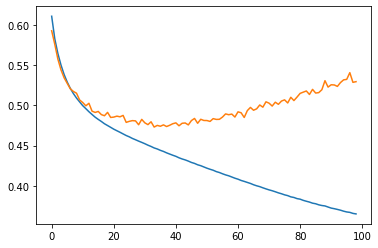

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_list[1:])
plt.plot(val_loss_list[1:])
plt.savefig('/project/hikaku_db/ziwei/Model_4/loss_plt_state_1.jpg')

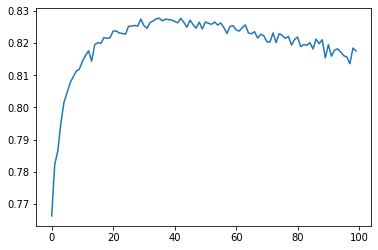

In [13]:
plt.plot(ac_list)
plt.savefig('/project/hikaku_db/ziwei/Model_4/ac_plt_state_1.jpg')

In [14]:
loss_list = pd.DataFrame([loss_list])
val_loss_list = pd.DataFrame([val_loss_list])
ac_list = pd.DataFrame([ac_list])
loss_list.to_csv('/project/hikaku_db/ziwei/Model_4/loss_list_state_1.csv',header=False,index=False)
val_loss_list.to_csv('/project/hikaku_db/ziwei/Model_4/val_loss_list_state_1.csv',header=False,index=False)
ac_list.to_csv('/project/hikaku_db/ziwei/Model_4/ac_list_state_1.csv',header=False,index=False)